In [9]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [2]:
#Set dataset

datasetDirectory = ""

In [7]:
#Import raw JIRA dataset
rawData_JIRA_MxShop = pd.read_excel('../data/01_raw/JIRA Mendix Engagement export_22_06_2021.xlsx')

#import
rawData_SVN_MxShop = loadCommits('../data/01_raw/MxShop-dump.txt')

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [4]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+|AFI+.[0-9]+|EM+.[0-9]+|OE+.[0-9]+|EM+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [5]:
#Start timer
startTime = time.time() 

intermediateData_SVN_MxShop = cleanCommitData(rawData_SVN_MxShop)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_MxShop.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_MxShop.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_MxShop.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_MxShop.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 1.6439402103424072 seconds


In [6]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rande\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [7]:
#Rename key to Issue key
rawData_JIRA_MxShop = rawData_JIRA_MxShop.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_MxShop = cleanJiraData(dataFrame = rawData_JIRA_MxShop, cleanComments = False, commentAmount = 39)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_MxShop.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_MxShop.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_MxShop.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_MxShop.pkl")

1/3) Finished Cleaning Summaries after 0.3699226379394531 sec
2/3) Finished Cleaning Description after 2.9697020053863525 sec
3/3) Finished Cleaning Dates after 2.9697020053863525 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [8]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [9]:
#Create JIRA corpus for MxShop dataset
intermediateData_JIRA_MxShopCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_MxShop.Summary)
intermediateData_JIRA_MxShopCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_MxShop.Description)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_MxShopCorpus = [i+" "+j for i,j in zip(intermediateData_JIRA_MxShopCorpusSummary,
                                                                             intermediateData_JIRA_MxShopCorpusDescription
                                                                            )]

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_MxShopCorpus, f)

Bigram corpora

In [10]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [11]:
#Create JIRA corpus for MxShop dataset
intermediateData_JIRA_MxShopCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_MxShop.Summary_2grams)
intermediateData_JIRA_MxShopCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_MxShop.Description_2grams)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_MxShopCorpus_2gram = [i+" "+j for i,j in zip(intermediateData_JIRA_MxShopCorpusSummary_2grams,
                                                                             intermediateData_JIRA_MxShopCorpusDescription_2grams
                                                                             )]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_MxShopCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_MxShopCorpus_2gram, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [12]:
intermediateData_SVN_MxShop = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_MxShop.pkl")

In [13]:
#Create corpus for log messages
intermediateData_SVNLogs_MxShopCorpus = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_MxShopCorpus = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_MxShopCorpus = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Logs + intermediateData_SVN_MxShop.Unit_names)
intermediateData_SVN_MxShopCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_MxShop.Logs + intermediateData_SVN_MxShop.Unit_names)
#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_MxShopCorpus, f)

with open('../data/02_intermediate/intermediateData_SVNUnitNames_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_MxShopCorpus, f)

with open('../data/02_intermediate/intermediateData_SVN_MxShopCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_MxShopCorpus, f)
    
with open('../data/02_intermediate/intermediateData_SVN_MxShopCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_MxShopCorpusAll, f)

bigram corpora

In [14]:
intermediateData_SVNLogs_MxShopCorpus_2gram = createCorpusNGrams(intermediateData_SVN_MxShop.Logs_2grams)
intermediateData_SVNUnitNames_MxShopCorpus_2gram = createCorpusNGrams(intermediateData_SVN_MxShop.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_MxShopCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_MxShopCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_MxShopCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_MxShopCorpus_2gram, f)

# 3. Preprocess Data

In [15]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_MxShop = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_MxShop.pkl")

intermediateData_SVN_MxShop = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_MxShop.pkl")

intermediateData_JIRA_MxShopCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_MxShopCorpus.pkl')
intermediateData_JIRA_MxShopCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_MxShopCorpus.pkl')
#intermediateData_SVN_MxShopCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_MxShopCorpusAll.pkl')
#intermediateData_SVN_MxShopCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_MxShopCorpusModel.pkl')
intermediateData_SVN_MxShopCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_MxShopCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [16]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

#Create cartesian products JIRA x Commits
processedData_MxShopCartesian = intermediateData_JIRA_MxShop.merge(intermediateData_SVN_MxShop, how='cross')
processedData_MxShopCartesian.info()
processedData_MxShopCartesian = processedData_MxShopCartesian.drop(processedData_MxShopCartesian[processedData_MxShopCartesian.Jira_created_date > processedData_MxShopCartesian.Commit_date].index)

#Create a pickle file for all intermediate datasets
processedData_MxShopCartesian.to_pickle(path= "../data/03_processed/processedData_MxShopCartesian.pkl")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 129970 entries, 0 to 129969
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Issue_key_jira              129970 non-null  object        
 1   Assignee                    62935 non-null   object        
 2   Jira_created_date           129970 non-null  datetime64[ns]
 3   Jira_updated_date           129970 non-null  datetime64[ns]
 4   Jira_resolved_date          85690 non-null   datetime64[ns]
 5   Summary                     129970 non-null  object        
 6   Summary_2grams              129970 non-null  object        
 7   Summary_3grams              129970 non-null  object        
 8   Description                 129970 non-null  object        
 9   Description_2grams          129970 non-null  object        
 10  Description_3grams          129970 non-null  object        
 11  Jira_natural_text           129970 non-

In [17]:
processedData_MxShopCartesian.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33627 entries, 1432 to 129969
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Issue_key_jira              33627 non-null  object        
 1   Assignee                    15017 non-null  object        
 2   Jira_created_date           33627 non-null  datetime64[ns]
 3   Jira_updated_date           33627 non-null  datetime64[ns]
 4   Jira_resolved_date          20409 non-null  datetime64[ns]
 5   Summary                     33627 non-null  object        
 6   Summary_2grams              33627 non-null  object        
 7   Summary_3grams              33627 non-null  object        
 8   Description                 33627 non-null  object        
 9   Description_2grams          33627 non-null  object        
 10  Description_3grams          33627 non-null  object        
 11  Jira_natural_text           33627 non-null  object

## 3.1 Preprocess Data - Create Labels

In [18]:
#Create new dataFrames for the time features
processedData_MxShopLabels = pd.DataFrame() 


#Create a column, which indicates which traces are valid.
processedData_MxShopLabels["is_valid"] = processedData_MxShopCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for MxShop")

#Save intermediate results
processedData_MxShopLabels.to_pickle(path= "../data/03_processed/processedData_MxShopLabels.pkl")

processedData_MxShopLabels.info()

Finished creating labels for MxShop
<class 'pandas.core.frame.DataFrame'>
Int64Index: 33627 entries, 1432 to 129969
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_valid  33627 non-null  bool 
dtypes: bool(1)
memory usage: 295.5 KB


In [19]:
#processedData_MxShopLabels[processedData_MxShopLabels.is_valid == True].count()
processedData_MxShopLabels[processedData_MxShopLabels.is_valid == True].count()

is_valid    86
dtype: int64

## 3.2 Preprocess Data - Create Time-Related Features

In [20]:
#Create new dataFrames for the time features
processedData_MxShopFeaturesTime = pd.DataFrame() 


#Calculate the time features for data Processing Dataset
processedData_MxShopFeaturesTime['Creation_commit_date_dif'] = processedData_MxShopCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_MxShopFeaturesTime['Updated_commit_date_dif'] = processedData_MxShopCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_MxShopFeaturesTime['Resolved_commit_date_dif'] = processedData_MxShopCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")

#Create a pickle file for all intermediate datasets
processedData_MxShopFeaturesTime.to_pickle(path= "../data/03_processed/processedData_MxShopFeaturesTime.pkl")

Finished data Processing


## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [21]:
#Create new dataFrames for the Stakeholder features
processedData_MxShopFeaturesStakeholder = pd.DataFrame() 

processedData_MxShopFeaturesStakeholder['Assignee_is_commiter'] = processedData_MxShopCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished MxShop")

#Create a pickle file for all intermediate datasets
processedData_MxShopFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_MxShopFeaturesStakeholder.pkl")


Finished MxShop


In [22]:
processedData_MxShopFeaturesStakeholder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33627 entries, 1432 to 129969
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Assignee_is_commiter  15017 non-null  float64
dtypes: float64(1)
memory usage: 525.4 KB


## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 MxShop - Cosine Similarity UniGrams

In [23]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)

def calculateCosineSimilarityNGrams(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [24]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       MxShop              #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_MxShopCountVectorizer = CountVectorizer()
processedData_SVN_MxShopCountTF_IDF = createFittedTF_IDF(processedData_SVN_MxShopCountVectorizer, intermediateData_SVN_MxShopCorpus)

processedData_SVNLogs_MxShopCountVectorizer = CountVectorizer()
processedData_SVNLogs_MxShopCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_MxShopCountVectorizer, intermediateData_SVNLogs_MxShopCorpus)

processedData_SVNUnitNames_MxShopCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_MxShopCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_MxShopCountVectorizer, intermediateData_SVNUnitNames_MxShopCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_MxShopCountVectorizer = CountVectorizer()
processedData_JIRA_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRA_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpus)

processedData_JIRASummaries_MxShopCountVectorizer = CountVectorizer()
processedData_JIRASummaries_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpusSummary)

processedData_JIRADescriptions_MxShopCountVectorizer = CountVectorizer()
processedData_JIRADescriptions_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRADescriptions_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpusDescription)

#processedData_JIRAComments_MxShopCountVectorizer = CountVectorizer()
#processedData_JIRAComments_MxShopCountTF_IDF = createFittedTF_IDF(processedData_JIRAComments_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpusComments)


################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_MxShopCountVectorizer_2gram, intermediateData_SVNLogs_MxShopCorpus_2gram)

processedData_SVNUnitNames_MxShopCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_MxShopCountVectorizer_2gram, intermediateData_SVNUnitNames_MxShopCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpus_2gram)

processedData_JIRASummaries_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRASummaries_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRASummaries_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpusSummary_2grams)

processedData_JIRADescriptions_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRADescriptions_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRADescriptions_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpusDescription_2grams)

#processedData_JIRAComments_MxShopCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
#processedData_JIRAComments_MxShopCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRAComments_MxShopCountVectorizer_2gram, intermediateData_JIRA_MxShopCorpusComments_2grams)




#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 36.552494287490845 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_MxShopCountVectorizer, processedData_SVNLogs_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 1 minutes and 29.413633108139038 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 58.07751989364624 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [28]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_MxShopCountVectorizer, processedData_JIRASummaries_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 36.897789478302 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_MxShopCountVectorizer, processedData_SVNLogs_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 27.165080308914185 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_MxShopCountVectorizer, processedData_JIRASummaries_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 6.59148907661438 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 49.10596036911011 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 2 minutes and 28.665664434432983 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [33]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.630343675613403 seconds


#### 3.4.5 [VSM unigram] Similarity between JIRA description and commit log - Description as query

In [34]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery["vsm_description_description_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_MxShopCountVectorizer, processedData_JIRADescriptions_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 28.8083758354187 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as descrintion

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionLogsAsQuery["vsm_description_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 32.44258522987366 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

#### 3.4.5 [VSM unigram Silarity between JIRA Comment and commit log - Comment as description

#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as description

#### [VSM bigram] Similarity between JIRA comments and Commit Logs - Logs as query

#### 3.4.5 [VSM bigram] Silarity between JIRA Comment and commit log - Comment as query

#### [VSM Unigram] Similarity between Unit Names and Description - Unit Names as query

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery["vsm_unitnames_description_unitnames_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.848024368286133 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Description as query

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery["vsm_unitnames_description_description_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRADescriptions_MxShopCountVectorizer, processedData_JIRADescriptions_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 3 minutes and 30.95453691482544 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Unit Names as query

#### [VSM Unigram] Similarity between Unit Names and Comments - Comments as query

In [38]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely)- JIRA as query

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnJiraJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnJiraJiraAsQuery["vsm_svn_jira_jira_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_MxShopCountVectorizer, processedData_JIRA_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnJiraJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnJiraJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 27.984426975250244 seconds


In [40]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely) - SVN as query

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnJiraSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnJiraSvnAsQuery["vsm_svn_jira_svn_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_MxShopCountVectorizer, processedData_SVN_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnJiraSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnJiraSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 30.733222246170044 seconds


In [42]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - SVN as query

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnSummarySvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnSummarySvnAsQuery["vsm_svn_summary_svn_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_SVN_MxShopCountVectorizer, processedData_SVN_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnSummarySvnAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnSummarySvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 34.67067837715149 seconds


In [44]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - Summary as query

In [45]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery["vsm_svn_summary_summary_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_JIRASummaries_MxShopCountVectorizer, processedData_JIRASummaries_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 38.994938135147095 seconds


In [46]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - SVN as query

In [47]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery["vsm_svn_description_svn_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_SVN_MxShopCountVectorizer, processedData_SVN_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 28.659072637557983 seconds


In [48]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - Description as query

In [49]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery["vsm_svn_description_description_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_JIRADescriptions_MxShopCountVectorizer, processedData_JIRADescriptions_MxShopCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 2 minutes and 25.517348289489746 seconds


In [50]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - SVN as query

In [51]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - Comments as query

#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [52]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer, processedData_SVNUnitNames_MxShopCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.126635551452637 seconds


#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [53]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_MxShopCountVectorizer_2gram, processedData_JIRA_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 41.305702924728394 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [54]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_MxShopCountVectorizer_2gram, processedData_SVNLogs_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 1 minutes and 22.484418153762817 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [55]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_MxShopCountVectorizer_2gram, processedData_JIRA_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 3 minutes and 42.50113916397095 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [56]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer_2gram, processedData_SVNUnitNames_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 26.30505657196045 seconds


#### [VSM bigram] Similarity between Logs and Description - Logs as Query

In [57]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram["vsm_description_log_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_MxShopCountVectorizer_2gram, processedData_SVNUnitNames_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 1 minutes and 28.103006839752197 seconds


#### [VSM bigram] Similarity between Logs and Description - Description as Query

In [58]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram["vsm_description_description_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_MxShopCountVectorizer_2gram, processedData_JIRADescriptions_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Bigrams' after " + timeDifference)

Finished creating 'VSM Bigrams' after 4 minutes and 9.035070180892944 seconds


#### [VSM bigram] Similarity between Logs and Summary - Logs as Query

#### [VSM bigram] Similarity between Logs and Summary - Summary as Query

In [59]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram["vsm_summary_logs_summary_as_query_2gram"] = processedData_MxShopCartesian.apply(lambda x: calculateCosineSimilarityNGrams(x.Summary, x.Logs, processedData_JIRASummaries_MxShopCountVectorizer_2gram, processedData_JIRASummaries_MxShopCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 2 minutes and 39.95780563354492 seconds


## 3.6 Document Statistics

### MxShop

In [60]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_MxShopFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_MxShopFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_MxShopFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_MxShopFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_MxShopFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_MxShopFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_MxShopFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_MxShopCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_MxShopFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_MxShopCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_MxShopFeaturesTotalWordCount["total_term_count_jira"] = processedData_MxShopCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_MxShopFeaturesTotalWordCount["total_term_count_svn"] = processedData_MxShopCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_MxShopFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_MxShopCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_MxShopFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_MxShopCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_MxShopFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_MxShopCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_MxShopFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesUniqueWordCount.pkl")
processedData_SVN_MxShopFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesUniqueWordCount.pkl")
processedData_JIRA_MxShopFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesTotalWordCount.pkl")
processedData_SVN_MxShopFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesTotalWordCount.pkl")

processedData_JIRA_MxShopFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesOverlapPercentage.pkl")
processedData_SVN_MxShopFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesOverlapPercentage.pkl")
processedData_UNION_MxShopFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_MxShopFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

Finished creating document statistics in 0 minutes and 6.188506126403809 seconds


## 3.7 Query Quality

In [61]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [62]:
#Read datasets from disk
processedData_MxShopCartesian = pd.read_pickle(r"../data/03_processed/processedData_MxShopCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_MxShopCountVectorizer = CountVectorizer()
processedData_SVN_MxShopTF_IDF = createFittedTF_IDF(processedData_SVN_MxShopCountVectorizer, intermediateData_SVN_MxShopCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_MxShopCountVectorizer = CountVectorizer()
processedData_JIRA_MxShopTF_IDF = createFittedTF_IDF(processedData_JIRA_MxShopCountVectorizer, intermediateData_JIRA_MxShopCorpus)

#Determine document counts
intermediateData_JIRA_MxShop_documentCount = len(intermediateData_JIRA_MxShop.index)
intermediateData_SVN_MxShop_documentCount = len(intermediateData_SVN_MxShop.index)



#### IDF Scores (SVN as Query)

In [63]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                processedData_SVN_MxShopTF_IDF),axis=1)

processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_MxShopFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 10 minutes and 14.41510558128357 seconds


#### IDF Scores (SVNLogs as Query)

In [64]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                processedData_SVNLogs_MxShopCountTF_IDF),axis=1)

processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_MxShopFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 33.564133644104004 seconds


#### IDF Scores (SVNUnitNames as Query

In [65]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                processedData_SVNLogs_MxShopCountTF_IDF),axis=1)

processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_MxShopFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 35.978662729263306 seconds


##### IDF Scores (JIRA as Query)

In [66]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                processedData_JIRA_MxShopTF_IDF),axis=1)

processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_MxShopFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 21 minutes and 5.251758813858032 seconds


##### IDF Scores (JIRA Summaries as Query)

In [67]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                processedData_JIRASummaries_MxShopCountTF_IDF),axis=1)

processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_avgIDF"] = processedData_JIRASummaries_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_maxIDF"] = processedData_JIRASummaries_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_MxShopFeaturesIDF["JiraSummariesAsQuery_devIDF"] = processedData_JIRASummaries_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraSummariesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 51.70895743370056 seconds


##### IDF Scores (JIRA Descriptions as Query)

In [68]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_IDF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_MxShopCountTF_IDF),axis=1)

processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_avgIDF"] = processedData_JIRADescriptions_MxShopFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_maxIDF"] = processedData_JIRADescriptions_MxShopFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_MxShopFeaturesIDF["JiraDescriptionsAsQuery_devIDF"] = processedData_JIRADescriptions_MxShopFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 18 minutes and 57.60263442993164 seconds


##### IDF Scores (JIRA Comments as Query)

#### ICTF Scores (SVN as query)

In [69]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesICTF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 18.29009437561035 seconds


#### ICTF Scores (SVNLogs as query)

In [70]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)
##
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 4.974921941757202 seconds


#### ICTF Scores (SVNUnitNames as query)

In [71]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)
##
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 9.75954294204712 seconds


#### ICTF Scores (JIRA as query)

In [72]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)
##
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 10.074624061584473 seconds


#### ICTF Scores (JIRA Summaries as query)

In [73]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)
##
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_avgICTF"] = processedData_JIRASummaries_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraSummariesAsQuery_ICTF, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_maxICTF"] = processedData_JIRASummaries_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraSummariesAsQuery_ICTF), axis=1)
processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_devICTF"] = processedData_JIRASummaries_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraSummariesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 5.033909797668457 seconds


#### ICTF Scores (JIRA Descriptions as query)

In [74]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_ICTF"] = processedData_MxShopCartesian.apply(lambda x: calcICTFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)
##
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"] = processedData_JIRADescriptions_MxShopFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraDescriptionsAsQuery_ICTF, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"] = processedData_JIRADescriptions_MxShopFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)
processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_devICTF"] = processedData_JIRADescriptions_MxShopFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 10.240581274032593 seconds


#### ICTF Scores (JIRA Comments as query)

#### Entropy (SVN as query)

In [75]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount,
                                                                                                                intermediateData_SVN_MxShop.Commit_natural_text),axis=1)

processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_maxEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesEntropy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 9 minutes and 14.774837255477905 seconds


#### Entropy (SVNLogs as query)

In [76]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount,
                                                                                                                intermediateData_SVN_MxShop.Logs),axis=1)
##
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 13.964986324310303 seconds


#### Entropy (SVNUnitNames as query)

In [77]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount,
                                                                                                                intermediateData_SVN_MxShop.Unit_names),axis=1)
##
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 8 minutes and 16.885059595108032 seconds


#### Entropy (JIRA as query)

In [78]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount,
                                                                                                                intermediateData_JIRA_MxShop.Jira_natural_text),axis=1)
##
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 12 minutes and 17.516865491867065 seconds


#### Entropy (JIRA Summaries as query)

In [79]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount,
                                                                                                                intermediateData_JIRA_MxShop.Summary),axis=1)
##
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_medEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_devEntropy"] = processedData_JIRASummaries_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 28.76693105697632 seconds


#### Entropy (JIRA Descriptions as query)

In [80]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_Entropy"] = processedData_MxShopCartesian.apply(lambda x: calcEntropyList(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount,
                                                                                                                intermediateData_JIRA_MxShop.Description),axis=1)
##
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"] = processedData_JIRADescriptions_MxShopFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 10 minutes and 45.120721101760864 seconds


#### Entropy (JIRA Comments as query)

##### Query Scope (SVN as query)

In [81]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_MxShop.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 17.95862650871277 seconds


##### Query Scope (SVNLogs as query)

In [82]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_MxShop.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 4.683569669723511 seconds


##### Query Scope (SVNUnitNames as query)

In [83]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_MxShop.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 11.099348783493042 seconds


##### Query Scope (JIRA as query)

In [84]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_MxShop.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 33.103233337402344 seconds


##### Query Scope (JIRA Summaries as query)

In [85]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesQueryScope["JiraSummariesAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Summary, 
                                                                                                                intermediateData_JIRA_MxShop.Summary),axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 12.632026433944702 seconds


##### Query Scope (JIRA Descriptions as query)

In [86]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesQueryScope["JiraDescriptionsAsQuery_QueryScope"] = processedData_MxShopCartesian.apply(lambda x: calcQueryScope(x.Description, 
                                                                                                                intermediateData_JIRA_MxShop.Description),axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 58.8698935508728 seconds


##### Query Scope (JIRA Comments as query)

#### Kullback-Leiber divergence (SVN as query)

In [87]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesSCS["SvnAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_SVN_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 27.842207193374634 seconds


#### Kullback-Leiber divergence (SVNLogs as query)

In [88]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 1.0254971981048584 seconds


#### Kullback-Leiber divergence (SVNUnitNames as query)

In [89]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_MxShopCountVectorizer, 
                                                                                                                intermediateData_SVN_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 26.339685678482056 seconds


#### Kullback-Leiber divergence (JIRA as query)

In [90]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesSCS["JiraAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.8916094303131104 seconds


#### Kullback-Leiber divergence (JIRA Summaries as query)

In [91]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesSCS["JiraSummariesAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Summary, 
                                                                                                                processedData_JIRASummaries_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 0.7705180644989014 seconds


In [92]:
##### Kullback-Leiber divergence (JIRA Description as query)

In [93]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesSCS["JiraDescriptionsAsQuery_SCS"] = processedData_MxShopCartesian.apply(lambda x: calcSCS(x.Description, 
                                                                                                                processedData_JIRADescriptions_MxShopCountVectorizer, 
                                                                                                                intermediateData_JIRA_MxShop_documentCount),axis=1)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.6688790321350098 seconds


In [94]:
##### Kullback-Leiber divergence (JIRA Comments as query)

#### SCQ (SVN as Query)

In [95]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_MxShop.Commit_natural_text,
                                                                                                                                         processedData_SVN_MxShopCountVectorizer,
                                                                                                                                         processedData_SVN_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 37.277780055999756 seconds


#### SCQ (SVNLogs as Query)

In [96]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_MxShop.Logs,
                                                                                                                                         processedData_SVNLogs_MxShopCountVectorizer,
                                                                                                                                         processedData_SVNLogs_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 35.51298451423645 seconds


#### SCQ (SVNUnitNames as Query)

In [97]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_MxShop.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_MxShopCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_SVN_MxShop_documentCount),axis=1)

processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_MxShop_documentCount), axis=1)
processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 34.50829553604126 seconds


#### SCQ (JIRA as Query)

In [98]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_MxShop.Jira_natural_text,
                                                                                                                                         processedData_JIRA_MxShopCountVectorizer,
                                                                                                                                         processedData_JIRA_MxShopTF_IDF,
                                                                                                                                         intermediateData_JIRA_MxShop_documentCount),axis=1)

processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 17.42868185043335 seconds


#### SCQ (JIRA Summaries as Query)

In [99]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Summary, intermediateData_JIRA_MxShop.Summary,
                                                                                                                                         processedData_JIRASummaries_MxShopCountVectorizer,
                                                                                                                                         processedData_JIRASummaries_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_MxShop_documentCount),axis=1)

processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"] = processedData_JIRASummaries_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraSummariesAsQuery_SCQ, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"] = processedData_JIRASummaries_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)
processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"] = processedData_JIRASummaries_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 38.22955060005188 seconds


#### SCQ (JIRA Descriptions as Query)

In [100]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_SCQ"] = processedData_MxShopCartesian.apply(lambda x: calcSCQList(x.Description, intermediateData_JIRA_MxShop.Description,
                                                                                                                                         processedData_JIRADescriptions_MxShopCountVectorizer,
                                                                                                                                         processedData_JIRADescriptions_MxShopCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_MxShop_documentCount),axis=1)

processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"] = processedData_JIRADescriptions_MxShopFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraDescriptionsAsQuery_SCQ, intermediateData_JIRA_MxShop_documentCount), axis=1)
processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"] = processedData_JIRADescriptions_MxShopFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)
processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"] = processedData_JIRADescriptions_MxShopFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 6.88383674621582 seconds


#### SCQ (JIRA Comments as Query)

#### PMI (SVN as query)

In [101]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_MxShopCountVectorizer, intermediateData_SVN_MxShop.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_MxShop.Commit_natural_text)

#Create new dataFrame
processedData_SVN_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_MxShop.Commit_natural_text),axis=1)

processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_MxShopFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 23 minutes and 12.832783937454224 seconds


#### PMI (SVNLogs as query)

In [102]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_MxShopCountVectorizer, intermediateData_SVN_MxShop.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_MxShop.Logs)

#Create new dataFrame
processedData_SVNLogs_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_MxShop.Logs),axis=1)

processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_MxShopFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 0 minutes and 12.646311521530151 seconds


#### PMI (SVNUnitNames as query)

In [103]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_MxShopCountVectorizer, intermediateData_SVN_MxShop.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_MxShop.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_MxShop.Unit_names),axis=1)

processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_MxShopFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 23 minutes and 30.655210733413696 seconds


#### PMI (JIRA as query)

In [104]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_MxShopCountVectorizer, intermediateData_JIRA_MxShop.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_MxShop.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_MxShop.Jira_natural_text),axis=1)

processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_MxShopFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 56 minutes and 31.482943534851074 seconds


#### PMI (JIRA Summaries as query)

In [105]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRASummaries_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRASummaries_MxShopCountVectorizer, intermediateData_JIRA_MxShop.Summary)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_MxShop.Summary)

#Create new dataFrame
processedData_JIRASummaries_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Summary, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_MxShop.Summary),axis=1)

processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_avgPMI"] = processedData_JIRASummaries_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraSummariesAsQuery_PMI), axis=1)
processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_maxPMI"] = processedData_JIRASummaries_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraSummariesAsQuery_PMI), axis=1)



processedData_JIRASummaries_MxShopFeaturesPMI.drop('JiraSummariesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRASummaries_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 2 minutes and 55.75448441505432 seconds


#### PMI (JIRA Descriptions as query)

In [106]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRADescriptions_MxShopCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRADescriptions_MxShopCountVectorizer, intermediateData_JIRA_MxShop.Description)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_MxShop.Description)

#Create new dataFrame
processedData_JIRADescriptions_MxShopFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_PMI"] = processedData_MxShopCartesian.apply(lambda x: calcPMIList(x.Description, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_MxShop.Description),axis=1)

processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"] = processedData_JIRADescriptions_MxShopFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)
processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"] = processedData_JIRADescriptions_MxShopFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)



processedData_JIRADescriptions_MxShopFeaturesPMI.drop('JiraDescriptionsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRADescriptions_MxShopFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-61-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 72 minutes and 43.08158731460571 seconds


#### PMI (JIRA Comments as query)

In [10]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def normalizeData(dataFrame):
    scaler = preprocessing.MinMaxScaler()
    names = dataFrame.columns
    d = scaler.fit_transform(dataFrame)
    scaledDataFrame = pd.DataFrame(d, columns=names)
    return(scaledDataFrame)

# Normalize all data

In [11]:
from sklearn import preprocessing
import numpy as np

################################## Loading #################################
#Load Process-Related Features
processedData_MxShopFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesTime.pkl')
processedData_MxShopFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_MxShop_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.pkl')

#processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery.pkl')
#processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl')

processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmDescriptionDescriptionAsQuery.pkl')
processedData_MxShop_features_VsmDescriptionLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmDescriptionLogsAsQuery.pkl')
#processedData_MxShop_features_VsmCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsCommentsAsQuery.pkl')
#processedData_MxShop_features_VsmCommentsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsLogsAsQuery.pkl')

processedData_MxShop_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_MxShop_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsSvnAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery.pkl')


#Load IR-Related Features - bigram
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')
#processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram.pkl')
#processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram.pkl')


#Load Document Statistics Features
processedData_JIRA_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesUniqueWordCount.pkl")
processedData_SVN_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesUniqueWordCount.pkl")
processedData_JIRA_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesTotalWordCount.pkl")
processedData_SVN_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesTotalWordCount.pkl")
processedData_JIRA_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesOverlapPercentage.pkl")
processedData_SVN_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesOverlapPercentage.pkl")
processedData_UNION_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_MxShopFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_MxShopFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesQueryQuality.pkl')
processedData_SVN_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesIDF.pkl')
processedData_SVNLogs_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesIDF.pkl')
processedData_SVNUnitNames_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesIDF.pkl')
processedData_JIRA_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesIDF.pkl')
processedData_JIRASummaries_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesIDF.pkl')
processedData_JIRADescriptions_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesIDF.pkl')
#processedData_JIRAComments_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesIDF.pkl')


processedData_SVN_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesICTF.pkl')
processedData_SVNLogs_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesICTF.pkl')
processedData_SVNUnitNames_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesICTF.pkl')
processedData_JIRA_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesICTF.pkl')
processedData_JIRASummaries_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesICTF.pkl')
processedData_JIRADescriptions_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesICTF.pkl')
#processedData_JIRAComments_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesICTF.pkl')


processedData_SVN_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesEntropy.pkl')
processedData_SVNLogs_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesEntropy.pkl')
processedData_SVNUnitNames_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesEntropy.pkl')
processedData_JIRA_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesEntropy.pkl')
processedData_JIRASummaries_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesEntropy.pkl')
processedData_JIRADescriptions_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesEntropy.pkl')
#processedData_JIRAComments_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesEntropy.pkl')


processedData_SVN_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesQueryScope.pkl')
processedData_SVNLogs_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesQueryScope.pkl')
processedData_SVNUnitNames_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesQueryScope.pkl')
processedData_JIRA_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesQueryScope.pkl')
processedData_JIRASummaries_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesQueryScope.pkl')
processedData_JIRADescriptions_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesQueryScope.pkl')
#processedData_JIRAComments_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesQueryScope.pkl')


processedData_SVN_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesSCS.pkl')
processedData_SVNLogs_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCS.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCS.pkl')
processedData_JIRA_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCS.pkl')
processedData_JIRASummaries_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCS.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCS.pkl')
#processedData_JIRAComments_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCS.pkl')


processedData_SVN_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesSCQ.pkl')
processedData_SVNLogs_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCQ.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCQ.pkl')
processedData_JIRA_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCQ.pkl')
processedData_JIRASummaries_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCQ.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCQ.pkl')
#processedData_JIRAComments_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCQ.pkl')


processedData_SVN_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesPMI.pkl')
processedData_SVNLogs_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesPMI.pkl')
processedData_SVNUnitNames_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesPMI.pkl')
processedData_JIRA_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesPMI.pkl')
processedData_JIRASummaries_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesPMI.pkl')
processedData_JIRADescriptions_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesPMI.pkl')
#processedData_JIRAComments_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesPMI.pkl')


################################## Drop query array for normalization ###############################################


processedData_SVN_MxShopFeaturesIDF.drop('SvnAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesIDF.drop('SvnLogsAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesIDF.drop('SvnUnitNamesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesIDF.drop('JiraAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesIDF.drop('JiraSummariesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesIDF.drop('JiraDescriptionsAsQuery_IDF', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesIDF.drop('JiraCommentsAsQuery_IDF', axis = 1, inplace=True)

processedData_SVN_MxShopFeaturesICTF.drop('SvnAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesICTF.drop('SvnLogsAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesICTF.drop('SvnUnitNamesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesICTF.drop('JiraAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesICTF.drop('JiraSummariesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesICTF.drop('JiraDescriptionsAsQuery_ICTF', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesICTF.drop('JiraCommentsAsQuery_ICTF', axis = 1, inplace=True)

processedData_SVN_MxShopFeaturesEntropy.drop('SvnAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesEntropy.drop('SvnLogsAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesEntropy.drop('SvnUnitNamesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesEntropy.drop('JiraAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesEntropy.drop('JiraSummariesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesEntropy.drop('JiraDescriptionsAsQuery_Entropy', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesEntropy.drop('JiraCommentsAsQuery_Entropy', axis = 1, inplace=True)

processedData_SVN_MxShopFeaturesSCQ.drop('SvnAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNLogs_MxShopFeaturesSCQ.drop('SvnLogsAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNUnitNames_MxShopFeaturesSCQ.drop('SvnUnitNamesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRA_MxShopFeaturesSCQ.drop('JiraAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRASummaries_MxShopFeaturesSCQ.drop('JiraSummariesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRADescriptions_MxShopFeaturesSCQ.drop('JiraDescriptionsAsQuery_SCQ', axis = 1, inplace=True)
#processedData_JIRAComments_MxShopFeaturesSCQ.drop('JiraCommentsAsQuery_SCQ', axis = 1, inplace=True)

################################## Normalizing ################################################

processedData_MxShopFeaturesTime_normalized = normalizeData(processedData_MxShopFeaturesTime)
processedData_MxShopFeaturesStakeholder_normalized = normalizeData(processedData_MxShopFeaturesStakeholder)

#Load IR-Related Features - unigram
processedData_MxShop_features_VsmLogsJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmLogsJiraAsQuery)
processedData_MxShop_features_VsmLogsLogAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmLogsLogAsQuery)
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesJiraAsQuery)
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery)
#processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery)
#processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery)
processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery)
processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery)

processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery)
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery)
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery)
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryLogsLogsAsQuery)
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery)
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery)
processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmDescriptionDescriptionAsQuery)
processedData_MxShop_features_VsmDescriptionLogsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmDescriptionLogsAsQuery)
#processedData_MxShop_features_VsmCommentsCommentsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmCommentsCommentsAsQuery)
#processedData_MxShop_features_VsmCommentsLogsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmCommentsLogsAsQuery)

processedData_MxShop_features_VsmSvnJiraJiraAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnJiraJiraAsQuery)
processedData_MxShop_features_VsmSvnJiraSvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnJiraSvnAsQuery)
processedData_MxShop_features_VsmSvnSummarySvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnSummarySvnAsQuery)
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnSummarySummaryAsQuery)
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery)
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery)
#processedData_MxShop_features_VsmSvnCommentsSvnAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnCommentsSvnAsQuery)
#processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery_normalized = normalizeData(processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery)



#Load IR-Related Features - bigram
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmLogsJiraAsQuery_2gram)
processedData_MxShop_features_VsmLogsLogAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmLogsLogAsQuery_2gram)
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram)
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram)
#processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmCommentsLogsAsQuery_2gram)
#processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram_normalized = normalizeData(processedData_MxShop_features_VsmCommentsCommentsAsQuery_2gram)


#Load Document Statistics Features
processedData_JIRA_MxShopFeaturesUniqueWordCount_normalized = normalizeData(processedData_JIRA_MxShopFeaturesUniqueWordCount)
processedData_SVN_MxShopFeaturesUniqueWordCount_normalized = normalizeData(processedData_SVN_MxShopFeaturesUniqueWordCount)
processedData_JIRA_MxShopFeaturesTotalWordCount_normalized = normalizeData(processedData_JIRA_MxShopFeaturesTotalWordCount)
processedData_SVN_MxShopFeaturesTotalWordCount_normalized = normalizeData(processedData_SVN_MxShopFeaturesTotalWordCount)
processedData_JIRA_MxShopFeaturesOverlapPercentage_normalized = normalizeData(processedData_JIRA_MxShopFeaturesOverlapPercentage)
processedData_SVN_MxShopFeaturesOverlapPercentage_normalized = normalizeData(processedData_SVN_MxShopFeaturesOverlapPercentage)
processedData_UNION_MxShopFeaturesOverlapPercentage_normalized = normalizeData(processedData_UNION_MxShopFeaturesOverlapPercentage)

#Load Query Quality Features
processedData_SVN_MxShopFeaturesIDF_normalized = normalizeData(processedData_SVN_MxShopFeaturesIDF)
processedData_SVNLogs_MxShopFeaturesIDF_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesIDF)
processedData_SVNUnitNames_MxShopFeaturesIDF_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesIDF)
processedData_JIRA_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRA_MxShopFeaturesIDF)
processedData_JIRASummaries_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesIDF)
processedData_JIRADescriptions_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesIDF)
#processedData_JIRAComments_MxShopFeaturesIDF_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesIDF)

processedData_SVN_MxShopFeaturesICTF_normalized = normalizeData(processedData_SVN_MxShopFeaturesICTF)
processedData_SVNLogs_MxShopFeaturesICTF_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesICTF)
processedData_SVNUnitNames_MxShopFeaturesICTF_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesICTF)
processedData_JIRA_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRA_MxShopFeaturesICTF)
processedData_JIRASummaries_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesICTF)
processedData_JIRADescriptions_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesICTF)
#processedData_JIRAComments_MxShopFeaturesICTF_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesICTF)

processedData_SVN_MxShopFeaturesEntropy_normalized = normalizeData(processedData_SVN_MxShopFeaturesEntropy)
processedData_SVNLogs_MxShopFeaturesEntropy_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesEntropy)
processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesEntropy)
processedData_JIRA_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRA_MxShopFeaturesEntropy)
processedData_JIRASummaries_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesEntropy)
processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesEntropy)
#processedData_JIRAComments_MxShopFeaturesEntropy_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesEntropy)

processedData_SVN_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_SVN_MxShopFeaturesQueryScope)
processedData_SVNLogs_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesQueryScope)
processedData_SVNUnitNames_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesQueryScope)
processedData_JIRA_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRA_MxShopFeaturesQueryScope)
processedData_JIRASummaries_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesQueryScope)
processedData_JIRADescriptions_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesQueryScope)
#processedData_JIRAComments_MxShopFeaturesQueryScope_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesQueryScope)

processedData_SVN_MxShopFeaturesSCS_normalized = normalizeData(processedData_SVN_MxShopFeaturesSCS)
processedData_SVNLogs_MxShopFeaturesSCS_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesSCS)
processedData_SVNUnitNames_MxShopFeaturesSCS_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesSCS)
processedData_JIRA_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRA_MxShopFeaturesSCS)
processedData_JIRASummaries_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesSCS)
processedData_JIRADescriptions_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesSCS)
#processedData_JIRAComments_MxShopFeaturesSCS_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesSCS)

processedData_SVN_MxShopFeaturesSCQ_normalized = normalizeData(processedData_SVN_MxShopFeaturesSCQ)
processedData_SVNLogs_MxShopFeaturesSCQ_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesSCQ)
processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesSCQ)
processedData_JIRA_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRA_MxShopFeaturesSCQ)
processedData_JIRASummaries_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesSCQ)
processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesSCQ)
#processedData_JIRAComments_MxShopFeaturesSCQ_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesSCQ)

processedData_SVN_MxShopFeaturesPMI_normalized = normalizeData(processedData_SVN_MxShopFeaturesPMI)
processedData_SVNLogs_MxShopFeaturesPMI_normalized = normalizeData(processedData_SVNLogs_MxShopFeaturesPMI)
processedData_SVNUnitNames_MxShopFeaturesPMI_normalized = normalizeData(processedData_SVNUnitNames_MxShopFeaturesPMI)
processedData_JIRA_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRA_MxShopFeaturesPMI)
processedData_JIRASummaries_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRASummaries_MxShopFeaturesPMI)
processedData_JIRADescriptions_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRADescriptions_MxShopFeaturesPMI)
#processedData_JIRAComments_MxShopFeaturesPMI_normalized = normalizeData(processedData_JIRAComments_MxShopFeaturesPMI)


## 3.8 Preprocess Data - Load and transform feature families needed for training

In [12]:

#Merge features into 1 dataframe
processedData_MxShopFeatures = pd.concat([processedData_MxShopFeaturesTime_normalized,
                                                  processedData_MxShopFeaturesStakeholder_normalized,
                                                  #IR-based
                                                  processedData_MxShop_features_VsmLogsJiraAsQuery_normalized,
                                                  processedData_MxShop_features_VsmLogsLogAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesJiraAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_normalized,
                                                #  processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryLogsLogsAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmDescriptionDescriptionAsQuery_normalized,
                                                  processedData_MxShop_features_VsmDescriptionLogsAsQuery_normalized,
                                                #  processedData_MxShop_features_VsmCommentsCommentsAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmCommentsLogsAsQuery_normalized,
                                                 # processedData_MxShop_features_VsmLogsJiraAsQuery_2gram_normalized,
                                                 # processedData_MxShop_features_VsmLogsLogAsQuery_2gram_normalized,
                                                 # processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram_normalized,
                                                 # processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized,
                                                  #processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized,
                                                 # processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnJiraJiraAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnJiraSvnAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnSummarySvnAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnSummarySummaryAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery_normalized,
                                                  processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmSvnCommentsSvnAsQuery_normalized,
                                               #   processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery_normalized,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_MxShopFeaturesUniqueWordCount_normalized,
                                                  processedData_SVN_MxShopFeaturesUniqueWordCount_normalized,
                                                  processedData_JIRA_MxShopFeaturesTotalWordCount_normalized,
                                                  processedData_SVN_MxShopFeaturesTotalWordCount_normalized,
                                                  processedData_JIRA_MxShopFeaturesOverlapPercentage_normalized,
                                                  processedData_SVN_MxShopFeaturesOverlapPercentage_normalized,
                                                  processedData_UNION_MxShopFeaturesOverlapPercentage_normalized,
                                                 #Query Quality
                                                  processedData_SVN_MxShopFeaturesIDF_normalized['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF_normalized['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF_normalized['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF_normalized['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF_normalized['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF_normalized['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF_normalized['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF_normalized['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF_normalized['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF_normalized['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF_normalized['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF_normalized['JiraAsQuery_devIDF'],  
                                                  processedData_JIRASummaries_MxShopFeaturesIDF_normalized['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF_normalized['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF_normalized['JiraSummariesAsQuery_devIDF'],  
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF_normalized['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF_normalized['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF_normalized['JiraDescriptionsAsQuery_devIDF'],  
                                               #   processedData_JIRAComments_MxShopFeaturesIDF_normalized['JiraCommentsAsQuery_avgIDF'],
                                               #   processedData_JIRAComments_MxShopFeaturesIDF_normalized['JiraCommentsAsQuery_maxIDF'],
                                               #   processedData_JIRAComments_MxShopFeaturesIDF_normalized['JiraCommentsAsQuery_devIDF'],  
                                                  
                                                  processedData_SVN_MxShopFeaturesICTF_normalized["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF_normalized["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF_normalized["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF_normalized["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF_normalized["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF_normalized["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF_normalized["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF_normalized["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF_normalized["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF_normalized["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF_normalized["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF_normalized["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF_normalized["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF_normalized["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF_normalized["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF_normalized["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF_normalized["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF_normalized["JiraDescriptionsAsQuery_devICTF"],
                                             #     processedData_JIRAComments_MxShopFeaturesICTF_normalized["JiraCommentsAsQuery_avgICTF"],
                                            #      processedData_JIRAComments_MxShopFeaturesICTF_normalized["JiraCommentsAsQuery_maxICTF"],
                                            #      processedData_JIRAComments_MxShopFeaturesICTF_normalized["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy_normalized["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy_normalized["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy_normalized["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy_normalized["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy_normalized["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy_normalized["JiraDescriptionsAsQuery_devEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_avgEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_medEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_maxEntropy"],
                                             # #    processedData_JIRAComments_MxShopFeaturesEntropy_normalized["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_MxShopFeaturesQueryScope_normalized,
                                                  processedData_SVNLogs_MxShopFeaturesQueryScope_normalized,
                                                  processedData_SVNUnitNames_MxShopFeaturesQueryScope_normalized,
                                                  processedData_JIRA_MxShopFeaturesQueryScope_normalized,
                                                  processedData_JIRASummaries_MxShopFeaturesQueryScope_normalized,
                                                  processedData_JIRADescriptions_MxShopFeaturesQueryScope_normalized,
                                                #  processedData_JIRAComments_MxShopFeaturesQueryScope_normalized,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCS_normalized,
                                                  processedData_SVNLogs_MxShopFeaturesSCS_normalized,
                                                  processedData_SVNUnitNames_MxShopFeaturesSCS_normalized,
                                                  processedData_JIRA_MxShopFeaturesSCS_normalized,
                                                  processedData_JIRASummaries_MxShopFeaturesSCS_normalized,
                                                  processedData_JIRADescriptions_MxShopFeaturesSCS_normalized,
                                            #      processedData_JIRAComments_MxShopFeaturesSCS_normalized,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCQ_normalized["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ_normalized["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ_normalized["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ_normalized["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ_normalized["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ_normalized["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ_normalized["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ_normalized["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ_normalized["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ_normalized["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ_normalized["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ_normalized["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ_normalized["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ_normalized["JiraDescriptionsAsQuery_sumSCQ"],
                                            #      processedData_JIRAComments_MxShopFeaturesSCQ_normalized["JiraCommentsAsQuery_avgSCQ"],
                                            #      processedData_JIRAComments_MxShopFeaturesSCQ_normalized["JiraCommentsAsQuery_maxSCQ"],
                                             #     processedData_JIRAComments_MxShopFeaturesSCQ_normalized["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_MxShopFeaturesPMI_normalized["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_MxShopFeaturesPMI_normalized["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI_normalized["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI_normalized["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI_normalized["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI_normalized["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI_normalized["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI_normalized["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI_normalized["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI_normalized["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI_normalized["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI_normalized["JiraDescriptionsAsQuery_maxPMI"],
                                            #      processedData_JIRAComments_MxShopFeaturesPMI_normalized["JiraCommentsAsQuery_avgPMI"],
                                             #     processedData_JIRAComments_MxShopFeaturesPMI_normalized["JiraCommentssAsQuery_maxPMI"],                                                  
                                                 ], axis=1)
#Set the NaN to 0
processedData_MxShopFeatures = processedData_MxShopFeatures.fillna(0)

#Saving feature names for later use
processedData_MxShopFeatureNames = list(processedData_MxShopFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_MxShopFeatures = np.array(processedData_MxShopFeatures)

#Load labels
processedData_MxShopLabels = pd.read_pickle(r'../data/03_processed/processedData_MxShopLabels.pkl')
processedData_MxShopLabels = np.array(processedData_MxShopLabels["is_valid"])


In [13]:
#Load Process-Related Features
processedData_MxShopFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesTime.pkl')
processedData_MxShopFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_MxShop_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_MxShop_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_MxShop_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsSvnAsQuery.pkl')
#processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery.pkl')
processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')

#Load IR-Related Features - bigram
processedData_MxShop_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')



#Load Document Statistics Features
processedData_JIRA_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesUniqueWordCount.pkl")
processedData_SVN_MxShopFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesUniqueWordCount.pkl")
processedData_JIRA_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesTotalWordCount.pkl")
processedData_SVN_MxShopFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesTotalWordCount.pkl")
processedData_JIRA_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_MxShopFeaturesOverlapPercentage.pkl")
processedData_SVN_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_MxShopFeaturesOverlapPercentage.pkl")
processedData_UNION_MxShopFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_MxShopFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_MxShopFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_MxShopFeaturesQueryQuality.pkl')
processedData_SVN_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_MxShopFeaturesIDF.pkl')
processedData_SVNLogs_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesIDF.pkl')
processedData_SVNUnitNames_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesIDF.pkl')
processedData_JIRA_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesIDF.pkl')
processedData_JIRASummaries_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesIDF.pkl')
processedData_JIRADescriptions_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesIDF.pkl')
#processedData_JIRAComments_MxShopFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesIDF.pkl')

processedData_SVNLogs_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesICTF.pkl')
processedData_SVNUnitNames_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesICTF.pkl')
processedData_JIRA_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesICTF.pkl')
processedData_JIRASummaries_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesICTF.pkl')
processedData_JIRADescriptions_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesICTF.pkl')
#processedData_JIRAComments_MxShopFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesICTF.pkl')


processedData_SVNLogs_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesEntropy.pkl')
processedData_SVNUnitNames_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesEntropy.pkl')
processedData_JIRA_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesEntropy.pkl')
processedData_JIRASummaries_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesEntropy.pkl')
processedData_JIRADescriptions_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesEntropy.pkl')
#processedData_JIRAComments_MxShopFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesEntropy.pkl')


processedData_SVNLogs_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesQueryScope.pkl')
processedData_SVNUnitNames_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesQueryScope.pkl')
processedData_JIRA_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesQueryScope.pkl')
processedData_JIRASummaries_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesQueryScope.pkl')
processedData_JIRADescriptions_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesQueryScope.pkl')
#processedData_JIRAComments_MxShopFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesQueryScope.pkl')


processedData_SVNLogs_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCS.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCS.pkl')
processedData_JIRA_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCS.pkl')
processedData_JIRASummaries_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCS.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCS.pkl')
#processedData_JIRAComments_MxShopFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCS.pkl')

processedData_SVNLogs_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesSCQ.pkl')
processedData_SVNUnitNames_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesSCQ.pkl')
processedData_JIRA_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesSCQ.pkl')
processedData_JIRASummaries_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesSCQ.pkl')
processedData_JIRADescriptions_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesSCQ.pkl')
#processedData_JIRAComments_MxShopFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesSCQ.pkl')


processedData_SVNLogs_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_MxShopFeaturesPMI.pkl')
processedData_SVNUnitNames_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_MxShopFeaturesPMI.pkl')
processedData_JIRA_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_MxShopFeaturesPMI.pkl')
processedData_JIRASummaries_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_MxShopFeaturesPMI.pkl')
processedData_JIRADescriptions_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_MxShopFeaturesPMI.pkl')
#processedData_JIRAComments_MxShopFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_MxShopFeaturesPMI.pkl')

#Merge features into 1 dataframe
processedData_MxShopFeatures = pd.concat([processedData_MxShopFeaturesTime,
                                                  processedData_MxShopFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_MxShop_features_VsmLogsJiraAsQuery,
                                                  processedData_MxShop_features_VsmLogsLogAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery,
                                               #   processedData_MxShop_features_VsmUnitNamesCommentsCommentsAsQuery,
                                               #   processedData_MxShop_features_VsmUnitNamesCommentsUnitNamesAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionDescriptionAsQuery,
                                                  processedData_MxShop_features_VsmUnitNamesDescriptionUnitNamesAsQuery,
                                                  processedData_MxShop_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_MxShop_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_MxShop_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  processedData_MxShop_features_VsmDescriptionDescriptionAsQuery,
                                                  processedData_MxShop_features_VsmDescriptionLogsAsQuery,
                                                  #processedData_MxShop_features_VsmCommentsCommentsAsQuery,
                                                  #processedData_MxShop_features_VsmCommentsLogsAsQuery,
                                                 # processedData_MxShop_features_VsmLogsJiraAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmLogsLogAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmUnitNamesJiraAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                 # processedData_MxShop_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                 # processedData_MxShop_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  processedData_MxShop_features_VsmSvnJiraJiraAsQuery,
                                                  processedData_MxShop_features_VsmSvnJiraSvnAsQuery,
                                                  processedData_MxShop_features_VsmSvnSummarySvnAsQuery,
                                                  processedData_MxShop_features_VsmSvnSummarySummaryAsQuery,
                                                  processedData_MxShop_features_VsmSvnDescriptionSvnAsQuery,
                                                  processedData_MxShop_features_VsmSvnDescriptionDescriptionAsQuery,
                                                #  processedData_MxShop_features_VsmSvnCommentsSvnAsQuery,
                                               #   processedData_MxShop_features_VsmSvnCommentsCommentsAsQuery,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_MxShopFeaturesUniqueWordCount,
                                                  processedData_SVN_MxShopFeaturesUniqueWordCount,
                                                  processedData_JIRA_MxShopFeaturesTotalWordCount,
                                                  processedData_SVN_MxShopFeaturesTotalWordCount,
                                                  processedData_JIRA_MxShopFeaturesOverlapPercentage,
                                                  processedData_SVN_MxShopFeaturesOverlapPercentage,
                                                  processedData_UNION_MxShopFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_MxShopFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_MxShopFeaturesIDF['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_MxShopFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_MxShopFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_MxShopFeaturesIDF['JiraAsQuery_devIDF'], 
                                                  processedData_JIRASummaries_MxShopFeaturesIDF['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_MxShopFeaturesIDF['JiraSummariesAsQuery_devIDF'], 
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_MxShopFeaturesIDF['JiraDescriptionsAsQuery_devIDF'], 
                                              #    processedData_JIRAComments_MxShopFeaturesIDF['JiraCommentsAsQuery_avgIDF'],
                                              #    processedData_JIRAComments_MxShopFeaturesIDF['JiraCommentsAsQuery_maxIDF'],
                                               #   processedData_JIRAComments_MxShopFeaturesIDF['JiraCommentsAsQuery_devIDF'], 
                                                  
                                                  processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_MxShopFeaturesICTF["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_MxShopFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_MxShopFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_MxShopFeaturesICTF["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_MxShopFeaturesICTF["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_MxShopFeaturesICTF["JiraDescriptionsAsQuery_devICTF"],
                                             #     processedData_JIRAComments_MxShopFeaturesICTF["JiraCommentsAsQuery_avgICTF"],
                                             #     processedData_JIRAComments_MxShopFeaturesICTF["JiraCommentsAsQuery_maxICTF"],
                                            #      processedData_JIRAComments_MxShopFeaturesICTF["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_MxShopFeaturesEntropy["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_MxShopFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_MxShopFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_MxShopFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_MxShopFeaturesEntropy["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_MxShopFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"],
                                               #   processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_medEntropy"],
                                              #    processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"],
                                               #   processedData_JIRAComments_MxShopFeaturesEntropy["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_MxShopFeaturesQueryScope,
                                                  processedData_SVNLogs_MxShopFeaturesQueryScope,
                                                  processedData_SVNUnitNames_MxShopFeaturesQueryScope,
                                                  processedData_JIRA_MxShopFeaturesQueryScope,
                                                  processedData_JIRASummaries_MxShopFeaturesQueryScope,
                                                  processedData_JIRADescriptions_MxShopFeaturesQueryScope,
                                             #     processedData_JIRAComments_MxShopFeaturesQueryScope,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCS,
                                                  processedData_SVNLogs_MxShopFeaturesSCS,
                                                  processedData_SVNUnitNames_MxShopFeaturesSCS,
                                                  processedData_JIRA_MxShopFeaturesSCS,
                                                  processedData_JIRASummaries_MxShopFeaturesSCS,
                                                  processedData_JIRADescriptions_MxShopFeaturesSCS,
                                             #     processedData_JIRAComments_MxShopFeaturesSCS,
                                                  
                                                  processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_MxShopFeaturesSCQ["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_MxShopFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_MxShopFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_MxShopFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_MxShopFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_MxShopFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"],
                                             #     processedData_JIRAComments_MxShopFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"],
                                             #     processedData_JIRAComments_MxShopFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"],
                                              #    processedData_JIRAComments_MxShopFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_MxShopFeaturesPMI["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_MxShopFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_MxShopFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_MxShopFeaturesPMI["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_MxShopFeaturesPMI["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_MxShopFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"],
                                              #    processedData_JIRAComments_MxShopFeaturesPMI["JiraCommentsAsQuery_avgPMI"],
                                              #    processedData_JIRAComments_MxShopFeaturesPMI["JiraCommentssAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_MxShopFeatures = processedData_MxShopFeatures.fillna(0)

#Saving feature names for later use
processedData_MxShopFeatureNames = list(processedData_MxShopFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_MxShopFeatures = np.array(processedData_MxShopFeatures)

#Load labels
processedData_MxShopLabels = pd.read_pickle(r'../data/03_processed/processedData_MxShopLabels.pkl')
processedData_MxShopLabels = np.array(processedData_MxShopLabels["is_valid"])


# 4. Modeling
First select which data set to train:


In [14]:
features = processedData_MxShopFeatures
labels = processedData_MxShopLabels

In [15]:
len(processedData_MxShopFeatures)

33627

In [16]:
processedData_MxShopFeatureNames

['Creation_commit_date_dif',
 'Updated_commit_date_dif',
 'Resolved_commit_date_dif',
 'Assignee_is_commiter',
 'vsm_logs_jira_as_query',
 'vsm_logs_log_as_query',
 'vsm_unit_names_jira_as_query',
 'vsm_unit_names_log_as_query',
 'vsm_unitnames_description_description_as_query',
 'vsm_unitnames_description_unitnames_as_query',
 'vsm_summary_logs_summary_as_query',
 'vsm_summary_logs_logs_as_query',
 'vsm_summary_unitNames_summary_as_query',
 'vsm_summary_unitNames_summary_as_query',
 'vsm_description_description_as_query',
 'vsm_description_log_as_query',
 'vsm_svn_jira_jira_as_query',
 'vsm_svn_jira_svn_as_query',
 'vsm_svn_summary_svn_as_query',
 'vsm_svn_summary_summary_as_query',
 'vsm_svn_description_svn_as_query',
 'vsm_svn_description_description_as_query',
 'unique_term_count_jira',
 'unique_term_count_svn',
 'total_term_count_jira',
 'total_term_count_svn',
 'overlap_percentage_compared_to_jira',
 'overlap_percentage_compared_to_svn',
 'overlap_percentage_compared_to_union',
 

In [17]:
processedData_MxShopFeatures

array([[-4.03818545e+06, -4.03636429e+06,  0.00000000e+00, ...,
         5.35343667e+00,  1.05940139e+00,  6.45204895e+00],
       [-4.66422909e+06, -4.66240793e+06,  0.00000000e+00, ...,
         5.35343667e+00,  1.05940139e+00,  6.45204895e+00],
       [-4.80705774e+06, -4.80523658e+06,  0.00000000e+00, ...,
         5.35343667e+00,  1.05940139e+00,  6.45204895e+00],
       ...,
       [-2.88401412e+07, -1.81404671e+07, -1.81404671e+07, ...,
         5.77118224e-01,  4.76179169e-01,  6.45204895e+00],
       [-2.94661848e+07, -1.87665107e+07, -1.87665107e+07, ...,
         5.77118224e-01,  4.76179169e-01,  6.45204895e+00],
       [-2.96090135e+07, -1.89093394e+07, -1.89093394e+07, ...,
         5.77118224e-01,  4.76179169e-01,  6.45204895e+00]])

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [18]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.2)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 26824, True: 77})


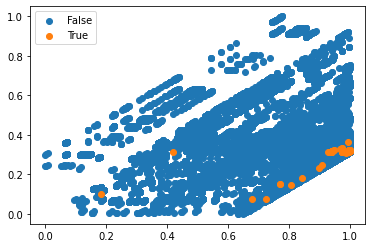

Counter({False: 26824, True: 24141})


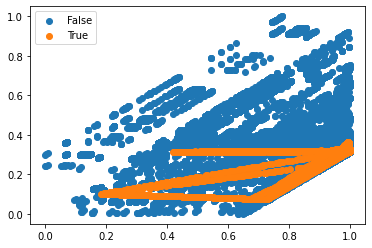

In [129]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.9)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.973536   0.074866  0.736842  0.135922  0.26616  0.091265   

   Average Precision  
0           0.055908  

--------------------------------------------------------------------


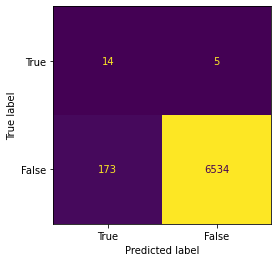

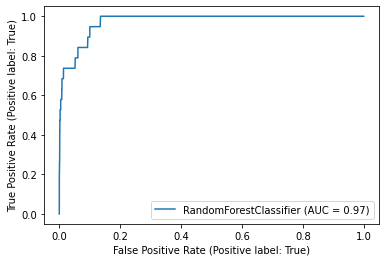

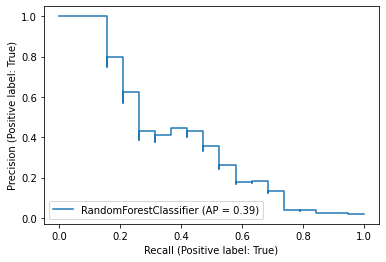

In [125]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_MxShopFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

In [ ]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# OLD Model Pipeline - Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier(n_jobs=-1, n_estimators = 3400, max_depth = 25)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# Model - Pipeline for GXBoost

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb


start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.1, n_jobs=2)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__n_estimators'] = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
space['classifier__max_depth'] = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
space['classifier__subsample'] = [0.7, 0.8, 0.9, 1.0]
space['classifier__learning_rate'] = [0.17, 0.18, 0.19, 0.2]
space['classifier__colsample_bytree'] = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__gamma'] = [0.01, 0.02, 0.03, 0.04, 0.05]

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:36:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1714.155 seconds
Cross-validation score: 0.8329283861320473
Test score: 0.7971014492753623
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 0.8}
0.017387914
0.023187198
0.048509862
0.0
0.017462779
0.025219457
0.0
0.006787189
0.019125199
0.0
0.04485659
0.014123082
0.0
0.0
0.022169633
0.0
0.01980644
0.0
0.0
0.004699794
0.0
0.0304516
0.008459342
0.0
0.0
0.0
0.0
0.0
0.01864229
0.009701973
0.0
0.0
0.007284407
0.0
0.008559288
0.0
0.0
0.0
0.0054326775
0.0076253614
0.021018364
0.0045094118
0.009215939
0.065427035
0.0
0.0
0.01086

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:03:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1618.755 seconds
Cross-validation score: 0.812616059962336
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.2}
0.028700061
0.019924155
0.04620611
0.0
0.029158324
0.008901393
0.0012772494
0.0
0.03670984
0.0
0.0
0.0
0.0
0.0
0.0
0.010975686
0.018276574
0.018458815
0.0
0.0031972472
0.0
0.0541827
0.004209339
0.0
0.0
0.0
0.0
0.0
0.020526579
0.0063623367
0.0
0.0026566624
0.013646889
0.0
0.0026239045
0.0
0.0
0.0018711269
0.03195529
0.0033116774
0.0059462884
0.0033635774
0.0041981186
0.0048804046


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1700.347 seconds
Cross-validation score: 0.8451379149135111
Test score: 0.8771929824561404
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.7}
0.04305141
0.03253571
0.06776076
0.0
0.063236825
0.022156537
0.0
0.0
0.0
0.0
0.04552217
0.0
0.0
0.0
0.036197696
0.0
0.030235296
0.0
0.0
0.0
0.0
0.04291311
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008531175
0.0
0.0
0.002607935
0.0
0.0
0.0
0.0
0.005941722
0.0
0.006878799
0.003185988
0.0028261805
0.0
0.0
0.0029886693
0.007863231
0.0070824022
0.0
0.0
0.0
0.008364263
0.0
0.0
0.0
0.0
0.0
0.0
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1693.036 seconds
Cross-validation score: 0.7819290192841533
Test score: 0.7692307692307693
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.6, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 1.0}
0.018321674
0.011427668
0.07320425
0.0
0.06969615
0.05986972
0.0
0.0
0.0
0.0
0.0
0.0048500607
0.0
0.0
0.030021489
0.0
0.0
0.0
0.0
0.0
0.0
0.033028778
0.009853025
0.0
0.0
0.0
0.0
0.0
0.0
0.018616185
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.014439625
0.005660434
0.0057602297
0.0
0.0
0.0
0.0
0.013808179
0.0
0.0
0.0
0.010828089
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008626336
0.09277732
0.0917

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:28:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1652.403 seconds
Cross-validation score: 0.8420020559424117
Test score: 0.8490566037735848
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.6, 'classifier__colsample_bytree': 0.5}
0.027378984
0.019352203
0.06106192
0.0
0.045794737
0.011398567
0.0
0.014269077
0.005214672
0.0
0.0
0.0
0.0
0.0
0.04700637
0.0
0.011909109
0.0
0.0
0.0
0.0
0.030685144
0.0066121356
0.0
0.0
0.0
0.0
0.0
0.0
0.0032676975
0.013463228
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.016592238
0.022416908
0.0027764994
0.0
0.0
0.0044440073
0.0
0.010496521
0.0
0.0
0.0
0.004024052
0.010383188
0.010850504

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:00:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1949.293 seconds
Cross-validation score: 0.8544511078651478
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.9}
0.011964898
0.020147132
0.020765206
0.0036705537
0.010681295
0.0051673036
0.0048464285
0.0
0.0
0.0044154427
0.016146477
0.005720252
0.006463113
0.0
0.018661149
0.0
0.0046562445
0.004954382
0.0
0.01486986
0.007704909
0.01792364
0.00954417
0.0
0.0
0.0
0.0
0.010584864
0.03416566
0.0052332366
0.011111981
0.0064512673
0.007440527
0.0037929206
0.008316923
0.0
0.0
0.0
0.006727326
0.03

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:27:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1606.105 seconds
Cross-validation score: 0.8308607345072982
Test score: 0.6923076923076923
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.9}
0.013852312
0.021991381
0.02529348
0.0064459364
0.009085839
0.0071401885
0.0077248183
0.0057944916
0.0
0.0
0.016114192
0.0077724247
0.0
0.0
0.013585351
0.0
0.026177995
0.0053041195
0.0085494565
0.0
0.016108792
0.020037362
0.006253135
0.0
0.0
0.0
0.0
0.007221951
0.0052839317
0.0
0.011152011
0.010125635
0.02330602
0.005960173
0.0054214844
0.0
0.008181714
0.0029321357
0.010427045
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_enco

[09:22:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 28517.973 seconds
Cross-validation score: 0.8448152447930998
Test score: 0.821917808219178
Best Hyperparameters: {'classifier__min_child_weight': 7, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.7}
0.020442277
0.022578474
0.03483195
0.0
0.017079279
0.011239521
0.014845448
0.010562364
0.0127258
0.0
0.024041107
0.024763223
0.0
0.0
0.0
0.0
0.02457653
0.0
0.0
0.019754268
0.0050282003
0.023262158
0.004965204
0.0
0.0
0.0
0.0
0.0
0.0
0.0048022573
0.0
0.005169628
0.0
0.0
0.010817798
0.0
0.0
0.0074339695
0.0033820278
0.00519671
0.006770644
0.01625578
0.0
0.008761312
0.0064858
0.04

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:48:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1549.914 seconds
Cross-validation score: 0.8447236499683536
Test score: 0.7692307692307693
Best Hyperparameters: {'classifier__min_child_weight': 6, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.4}
0.044589203
0.011195919
0.053482465
0.0
0.034458198
0.00941479
0.0
0.0
0.017626991
0.0
0.018137021
0.0121693155
0.0
0.0
0.0
0.0
0.038313646
0.0
0.0
0.0
0.0039799935
0.022985725
0.007059128
0.0
0.0055490932
0.0
0.0
0.0
0.020949632
0.0
0.0
0.004633479
0.00546894
0.024794381
0.0029285816
0.014234319
0.013712658
0.0044190916
0.0051700817
0.007245103
0.0032266178
0.014191779
0.0
0.005

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:15:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1641.138 seconds
Cross-validation score: 0.8208386987415555
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.1}
0.024907924
0.01548107
0.066989526
0.0
0.03585393
0.0073293694
0.0073983036
0.0
0.022302132
0.0
0.0
0.013030985
0.0
0.0
0.0
0.0031123986
0.021928623
0.0
0.009412632
0.020047843
0.02160982
0.02938292
0.0022378308
0.011548985
0.005389054
0.0
0.0
0.028834915
0.0
0.007918232
0.0012933855
0.0
0.0
0.0
0.0
0.0037051335
0.0
0.0023379906
0.028177422
0.014005343
0.007518822
0.014619165
0.

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:41:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1545.692 seconds
Cross-validation score: 0.8135269543330367
Test score: 0.7017543859649122
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.6, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.2}
0.09487895
0.01968115
0.049871992
0.0
0.040699225
0.0
0.0027758372
0.0
0.03567971
0.0
0.02418668
0.0
0.0
0.0
0.0
0.020548448
0.030836526
0.0
0.00036433878
0.011061352
0.036743067
0.029931633
0.003312334
0.0
0.0
0.0
0.0
0.007988545
0.0
0.0
0.0
0.0028218797
0.0
0.0
0.0
0.0
0.0
0.0
0.04836955
0.0026637553
0.008313725
0.004504802
0.0
0.017505242
0.0040845345
0.009053304
0.00987915


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:11:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1809.151 seconds
Cross-validation score: 0.8438532438310988
Test score: 0.7692307692307693
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.55, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.8}
0.033821527
0.025295148
0.0694597
0.0
0.084383935
0.01562561
0.0028633005
0.0
0.0
0.0
0.0
0.01948367
0.0
0.0
0.014564526
0.0
0.03712645
0.0
0.0
0.0
0.0
0.06501814
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.018669471
0.0
0.0
0.0018674526
0.0
0.0
0.0
0.0
0.0
0.0
0.02207408
0.0
0.006982547
0.0
0.0
0.01949146
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.012835409
0.0030707899
0.0784470

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:38:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1583.404 seconds
Cross-validation score: 0.8102977952907826
Test score: 0.8235294117647058
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.55, 'classifier__gamma': 0.3, 'classifier__colsample_bytree': 0.9}
0.026865477
0.021853345
0.07069253
0.0
0.035447247
0.012481068
0.0
0.0
0.0
0.0
0.06373691
0.0021838585
0.0
0.0
0.022155978
0.0
0.0019551395
0.0
0.0
0.0
0.0068509094
0.027501931
0.006762345
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0023063838
0.0
0.0
0.0147850225
0.0
0.0
0.0
0.018149495
0.0076151304
0.0
0.0030672983
0.0
0.0
0.013740751
0.0
0.008193111
0.0
0.0
0.0
0.016151143
0.002142808

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1618.596 seconds
Cross-validation score: 0.8199244605201643
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.6}
0.033392563
0.012475201
0.07779989
0.0
0.028814366
0.054323703
0.0
0.0
0.0
0.0
0.0
0.01416785
0.0
0.0
0.030374665
0.0
0.041917752
0.0
0.0
0.0
0.0
0.030527635
0.004510073
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.008874037
0.008879763
0.0057724556
0.0055293515
0.0
0.0
0.0
0.0041156104
0.0
0.0
0.0
0.010293523
0.0
0.013846825
0.0
0.0
0.0
0.0100260535
0.0
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:31:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1577.642 seconds
Cross-validation score: 0.8497299622751753
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.45, 'classifier__gamma': 0.2, 'classifier__colsample_bytree': 0.5}
0.021560512
0.027839275
0.051766373
0.0
0.030643342
0.018056085
0.0
0.0
0.0
0.0
0.0
0.0044640508
0.0
0.0
0.0
0.0
0.019562054
0.0
0.0
0.0
0.0
0.03433429
0.004048693
0.0
0.0
0.0
0.0
0.0
0.0
0.00678215
0.0032386028
0.0032997862
0.0
0.0
0.01690284
0.0
0.0
0.0
0.0017157439
0.020879833
0.009221524
0.0025563424
0.0
0.022975344
0.005690689
0.007867163
0.0029576393
0.0
0.0
0.0
0.00714723

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:55:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1463.951 seconds
Cross-validation score: 0.8446542141972865
Test score: 0.7142857142857142
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 18, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.1}
0.026732758
0.037726726
0.06077956
0.0
0.017914757
0.008229824
0.015086775
0.0
0.016408673
0.0
0.0
0.013863689
0.019972391
0.0
0.0
0.004130502
0.013439454
0.01399612
0.0045120697
0.008067756
0.015026296
0.030410785
0.0030196575
0.0
0.008142442
0.0062180515
0.0
0.0
0.0
0.006456691
0.0
0.0027621996
0.0017594278
0.005756169
0.0072576
0.0026513415
0.016707871
0.005406138
0.022539593

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1552.473 seconds
Cross-validation score: 0.8542276096974553
Test score: 0.7547169811320755
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.6, 'classifier__colsample_bytree': 0.5}
0.024931524
0.03822822
0.04687051
0.0
0.01965612
0.02132261
0.014990511
0.0
0.0077291424
0.0
0.036588494
0.016875412
0.0
0.0
0.017739933
0.0
0.0029495233
0.0
0.0
0.0
0.0
0.015647806
0.005741821
0.0
0.0
0.0
0.0
0.0
0.0
0.011229184
0.0
0.0
0.011563364
0.0
0.0
0.0
0.0
0.0
0.0058031385
0.007931607
0.012196987
0.045818765
0.0
0.015322033
0.0073864046
0.020241577
0.011707165
0.0
0.0


C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:48:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1615.634 seconds
Cross-validation score: 0.8458783990820603
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.5, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.1}
0.025749452
0.004644315
0.05867049
0.0
0.03516347
0.0045514656
0.009686741
0.0
0.04512978
0.0
0.0
0.0
0.020791376
0.0
0.0
0.013732168
0.020636719
0.0
0.0
0.045236383
6.9532085e-05
0.036768816
0.0
0.014264507
0.0
0.0
0.0033193193
0.0
0.0
0.0039813183
0.0
0.0
0.0
0.0
0.005506706
0.0
0.0
0.0
0.0034413298
0.012234182
0.011307478
0.008440884
0.019843698
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1316.469 seconds
Cross-validation score: 0.85719565122754
Test score: 0.7547169811320755
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 8, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.7, 'classifier__colsample_bytree': 0.4}
0.03427433
0.024026891
0.059154663
0.0
0.02670473
0.01309761
0.0032554117
0.017992172
0.012032217
0.0
0.025996964
0.0153171485
0.0
0.0
0.021596195
0.0
0.007035267
0.0
0.0
0.0
0.0
0.026622672
0.0068079936
0.0
0.0
0.0
0.0
0.0
0.0
0.006192505
0.0
0.0
0.0
0.0
0.011458404
0.002992041
0.0
0.015967546
0.0
0.0050261426
0.00918426
0.0038674907
0.0
0.0
0.01098137
0.013812696
0.0063290223
0.

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1618.109 seconds
Cross-validation score: 0.8548806139195155
Test score: 0.7894736842105263
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.4, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.4}
0.053036023
0.025047049
0.049370904
0.0
0.03856293
0.0
0.0
0.0
0.0
0.0
0.021348845
0.014576314
0.0
0.0
0.036042333
0.0
0.0
0.0
0.0
0.0
0.0
0.014758381
0.0084349075
0.0
0.005643399
0.0
0.0
0.0
0.0
0.009489514
0.0
0.0030900752
0.008831001
0.0
0.0
0.0
0.0
0.00019795279
0.0
0.011011216
0.0033490395
0.004884226
0.0
0.022805437
0.012400437
0.0
0.012034617
0.0
0.0
0.0
0.0
0.0
0.0020313

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:04:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1590.350 seconds
Cross-validation score: 0.8464678721894343
Test score: 0.8490566037735848
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.8, 'classifier__colsample_bytree': 0.7}
0.019652613
0.031945977
0.049260207
0.0
0.030905545
0.0281318
0.003397284
0.0077405185
0.0
0.0
0.052933987
0.02028257
0.0
0.0
0.0
0.0
0.026101062
0.0
0.0
0.0
0.0
0.018232187
0.007995358
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.027188566
0.007074063
0.0
0.0
0.0
0.0
0.0
0.003278768
0.009361759
0.017897118
0.0056759757
0.0
0.0
0.013334361
0.0
0.0
0.0
0.0
0.0
0.0064019533
0.0
0.0
0.0
0.0
0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:31:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1655.128 seconds
Cross-validation score: 0.8129378104760109
Test score: 0.8163265306122449
Best Hyperparameters: {'classifier__min_child_weight': 9, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.4}
0.026006244
0.022046484
0.045029353
0.0
0.019284198
0.017917275
0.01033071
0.007340756
0.0101024825
0.0
0.014959042
0.02415356
0.0
0.0
0.016830893
0.0
0.01412655
0.0
0.0
0.0
0.05137559
0.020309493
0.0042034127
0.012052975
0.0
0.0
0.0
0.0
0.0
0.010477022
0.0
0.0
0.004926236
0.0
0.0
0.0073308377
0.0
0.0
0.0031581637
0.007556921
0.008704364
0.0
0.0
0.0
0.0060570766
0.023115661
0.0

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1610.341 seconds
Cross-validation score: 0.8205601271372291
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 1, 'classifier__max_depth': 16, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.6}
0.011550461
0.011604438
0.02895118
0.013118866
0.0100187855
0.009646072
0.0
0.0
0.0033081407
0.0
0.010277249
0.007582264
0.0067554377
0.0
0.014296851
0.0
0.006252659
0.0032773053
0.0003319789
0.011039456
0.0034187606
0.0014939051
0.01355025
0.003963089
0.0060328627
0.0
0.0
0.0059904745
0.005005407
0.0067595853
0.0074776006
0.009531767
0.008361477
0.0033710464
0.0046621943
0.0081

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1604.186 seconds
Cross-validation score: 0.8153019444596916
Test score: 0.8196721311475408
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.25, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.2}
0.027775861
0.013272541
0.045608334
0.0
0.022138378
0.017839454
0.0
0.0
0.013191399
0.0
0.03345795
0.0076160557
0.0
0.0
0.022416987
0.0029436173
0.0072338195
0.0
0.0050097983
0.007875052
0.009264523
0.008814718
0.002067263
0.0
0.010246973
0.0
0.055512976
0.0
0.006830457
0.008872026
0.0
0.001894556
0.0
0.0
0.007602263
0.011005656
0.0
0.0
0.0
0.0132987965
0.0061636777
0.0016034539

C:\Users\rande\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:52:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 1633.971 seconds
Cross-validation score: 0.8478528673959396
Test score: 0.9016393442622951
Best Hyperparameters: {'classifier__min_child_weight': 6, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.9, 'classifier__colsample_bytree': 0.1}
0.035369776
0.014893533
0.06803456
0.0
0.02939984
0.0036060254
0.011022779
0.0
0.02052114
0.0
0.0
0.0047865217
0.0
0.022504857
0.008618528
0.005266931
0.012935544
0.0
0.0
0.016192578
0.020130567
0.020178556
0.022035925
0.0165817
0.009085895
0.0
0.00216698
0.0
0.0
0.009083301
0.0
0.008643912
0.0
0.0054228567
0.0035533593
0.0062441174
0.023199294
0.004024435
0.003312061
0.00933178

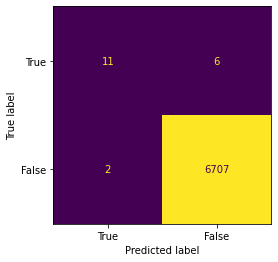

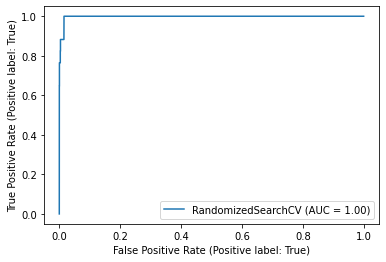

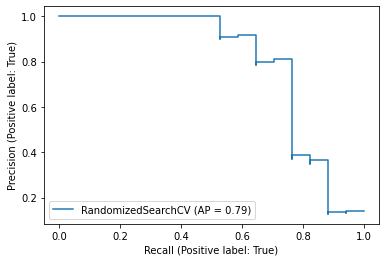

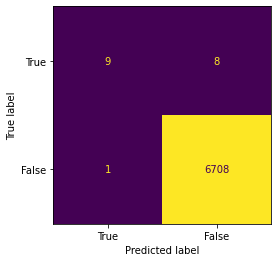

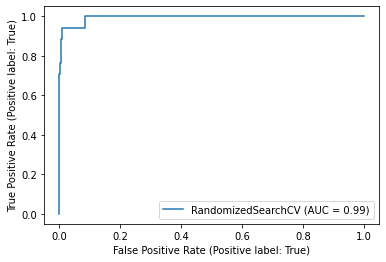

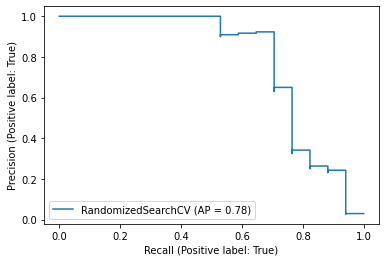

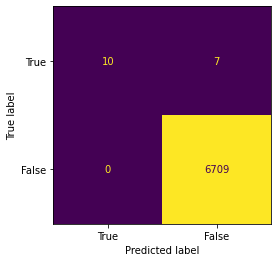

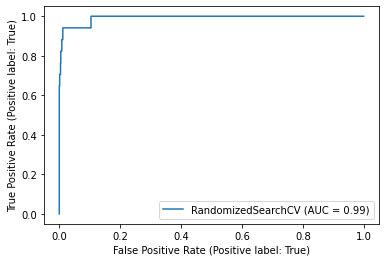

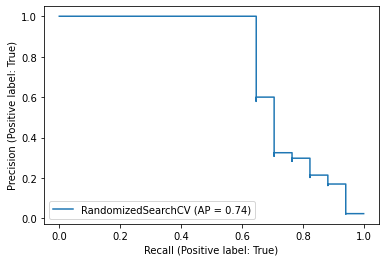

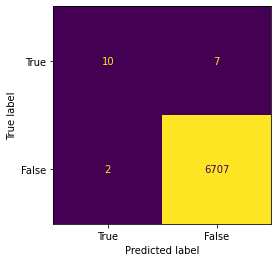

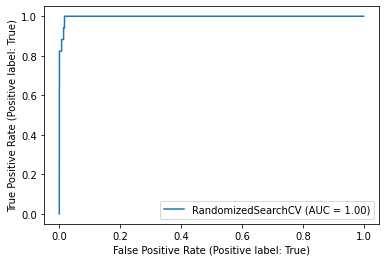

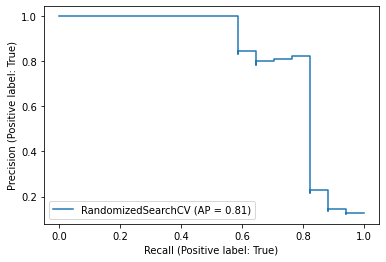

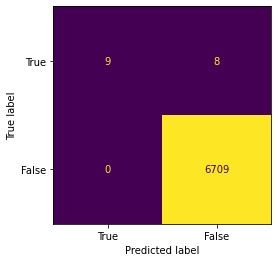

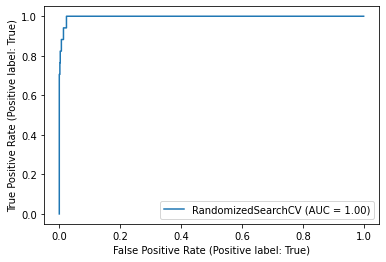

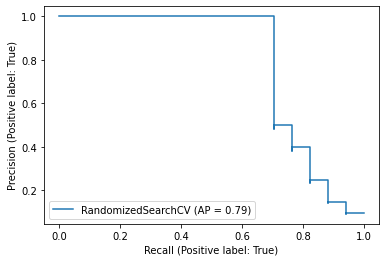

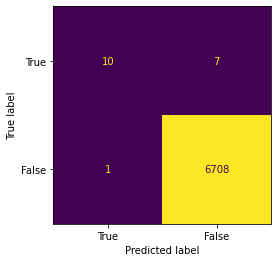

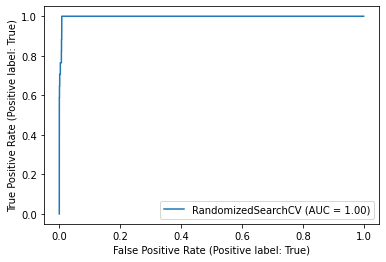

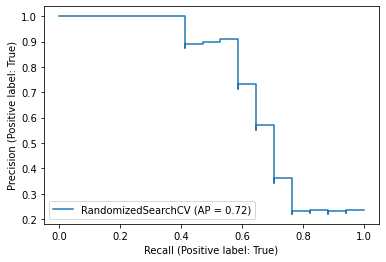

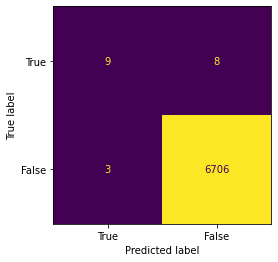

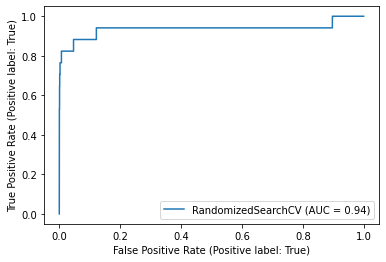

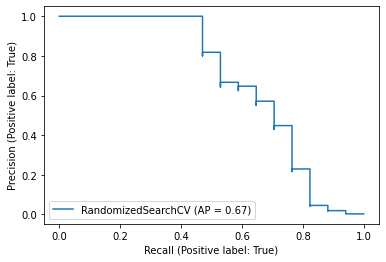

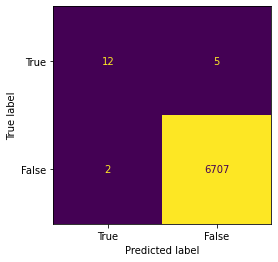

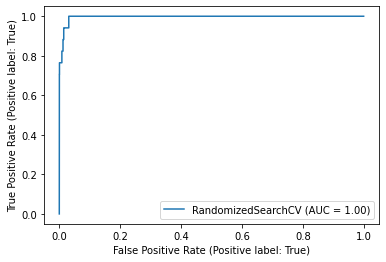

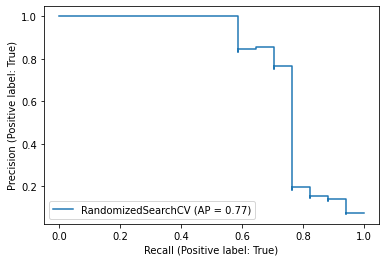

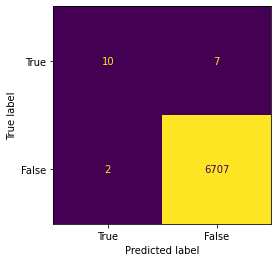

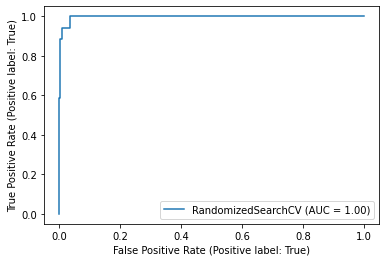

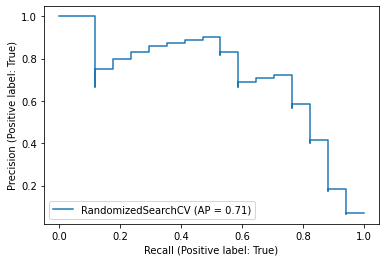

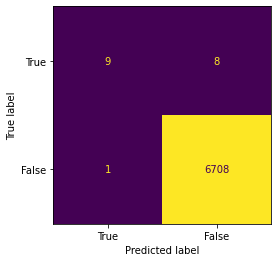

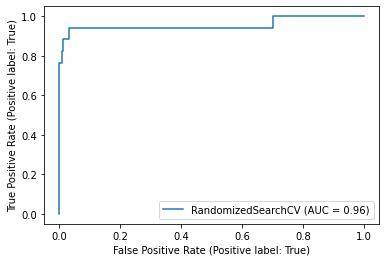

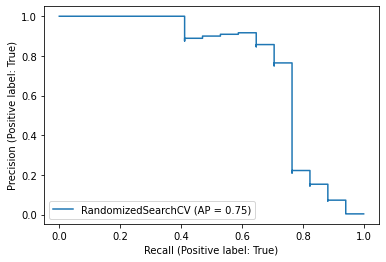

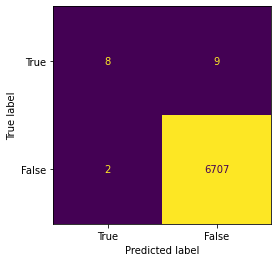

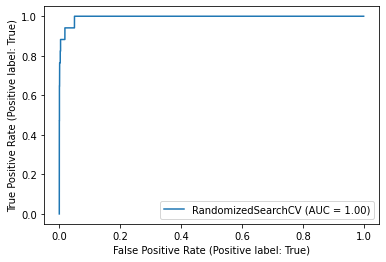

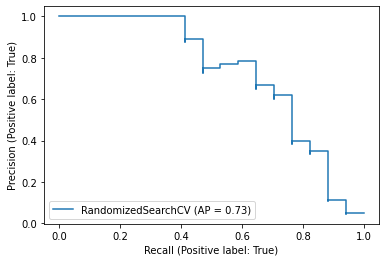

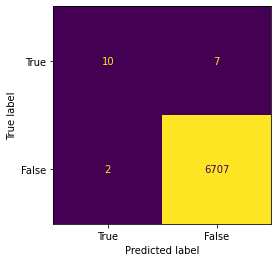

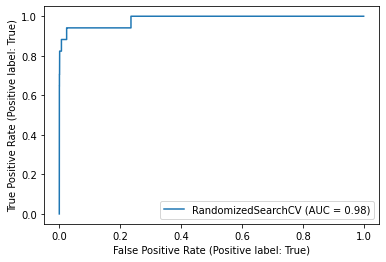

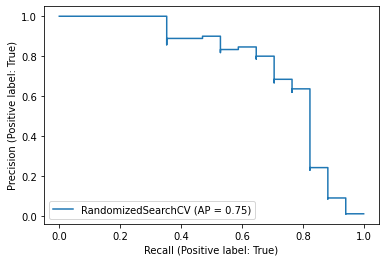

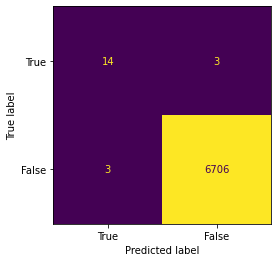

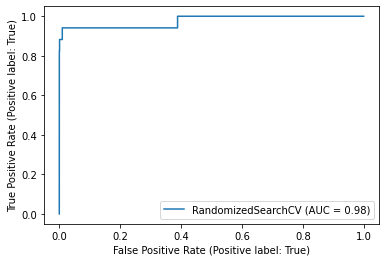

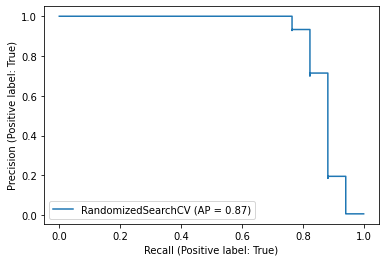

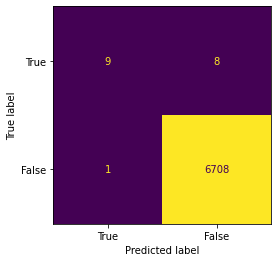

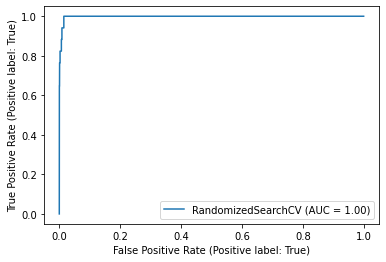

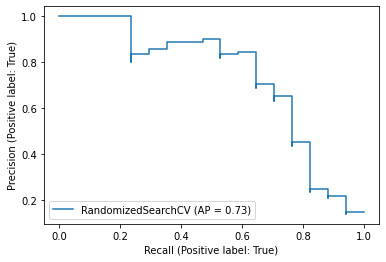

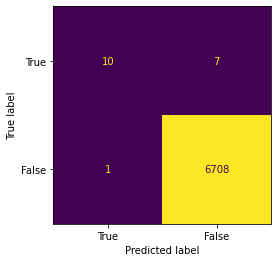

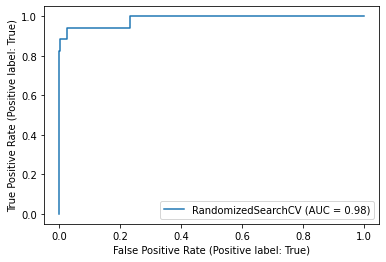

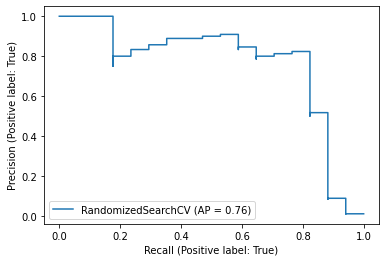

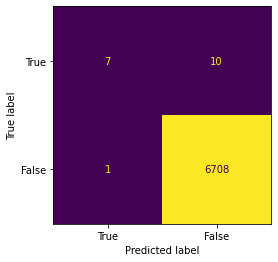

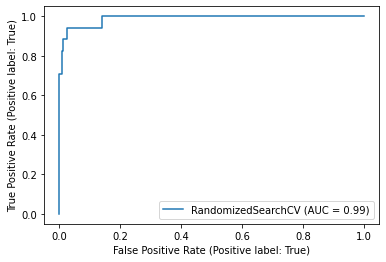

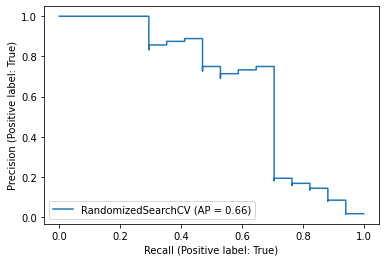

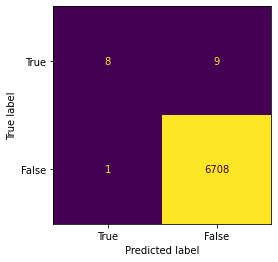

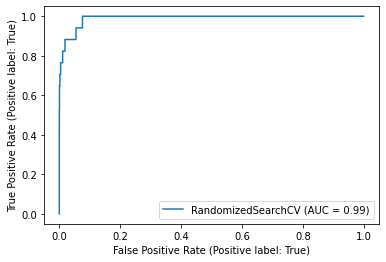

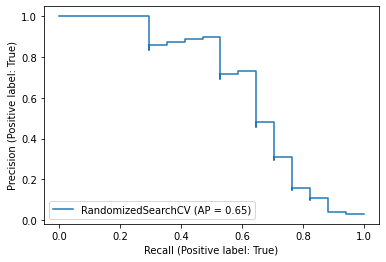

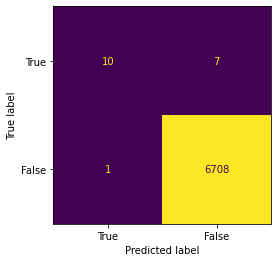

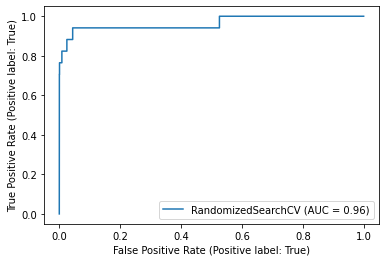

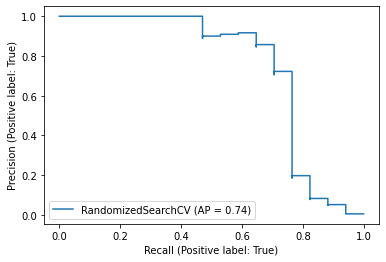

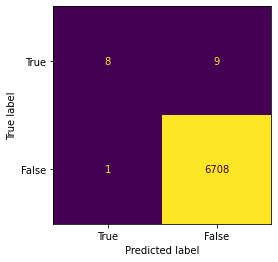

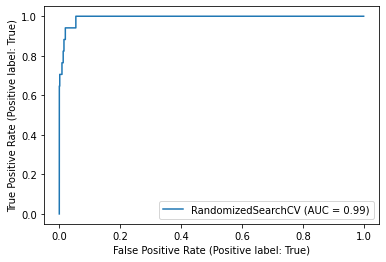

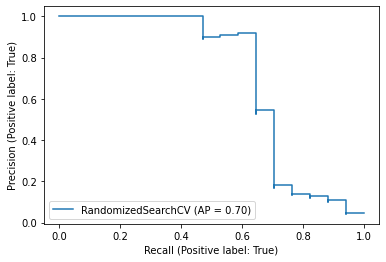

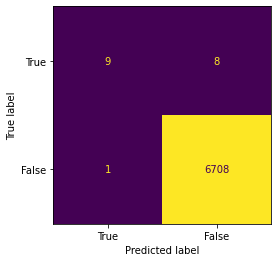

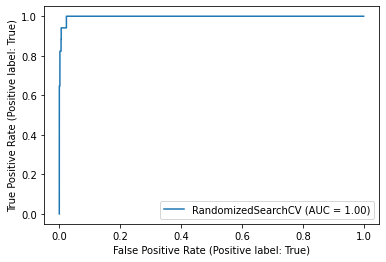

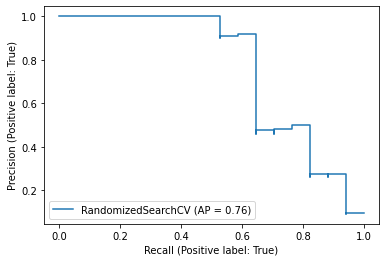

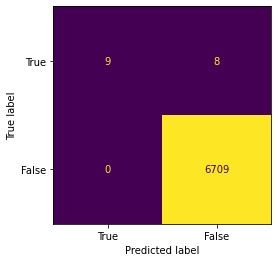

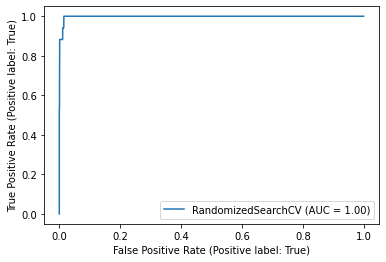

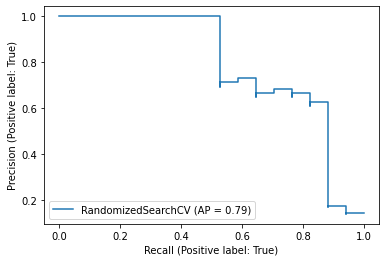

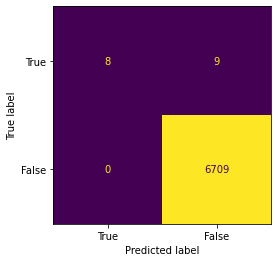

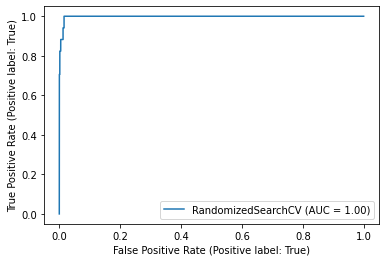

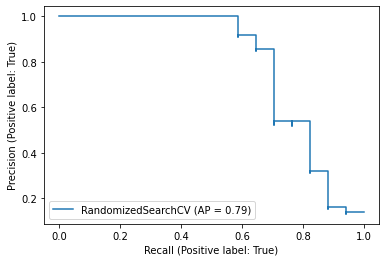

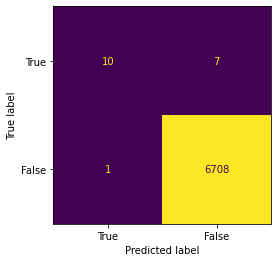

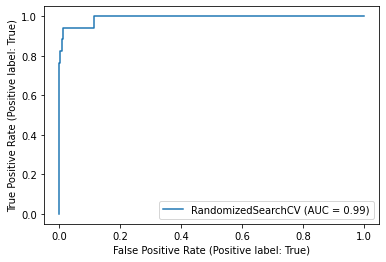

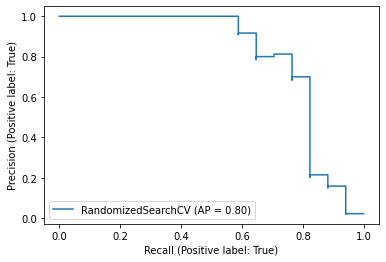

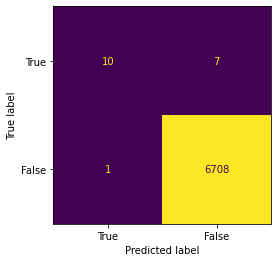

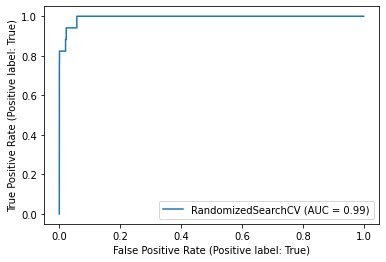

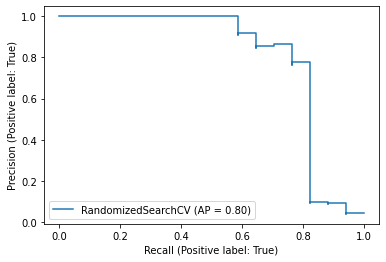

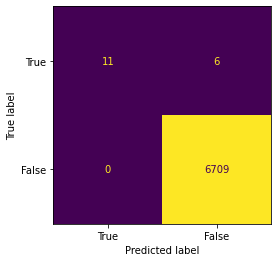

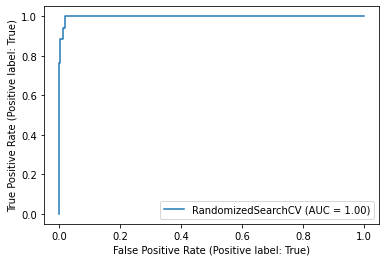

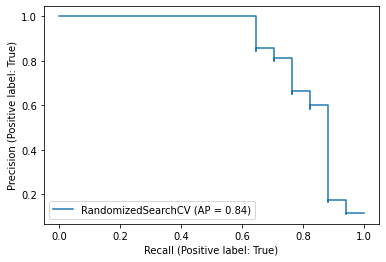

In [9]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

for i in range(25):
    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    spaceEmpty = dict()

    GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring=fhalf_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)
    
    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    
    cv_score = optimizedGXBoostModel.best_score_
    test_score = optimizedGXBoostModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)
    
    #feature importance
    importances = optimizedGXBoostModel.best_estimator_._final_estimator.feature_importances_
    for i,v in enumerate(importances):
        print(v)

    #Display the model performance    
    showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Random Forests

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.1, n_jobs=2)],
                             ['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]


search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.256 seconds
Cross-validation score: 0.08045029396404753
Test score: 0.06435643564356436
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0    0.9438   0.033592  0.764706  0.064356  0.142857  0.041534   

   Average Precision  
0           0.026283  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.280 seconds
Cross-validation score: 0.0654886628710359
Test score: 0.08808290155440415
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision  Recall        F1        F2      F0.5  \
0  0.947666    0.04607     1.0  0.088083  0.194508  0.056932   

   Average Precision  
0            0.04607  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.225 seconds
Cross-validation score: 0.05817922529830365
Test score: 0.06779661016949153
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.934582   0.035165  0.941176  0.067797  0.152964  0.043549   

   Average Precision  
0           0.033245  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.281 seconds
Cross-validation score: 0.06890022103334739
Test score: 0.09115281501340483
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision  Recall        F1        F2      F0.5  \
0  0.949599   0.047753     1.0  0.091153  0.200472  0.058987   

   Average Precision  
0           0.047753  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.264 seconds
Cross-validation score: 0.06996407967359262
Test score: 0.09065155807365437
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2     F0.5  \
0  0.952275   0.047619  0.941176  0.090652  0.19802  0.05878   

   Average Precision  
0           0.044967  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.187 seconds
Cross-validation score: 0.09186018094752672
Test score: 0.07669616519174041
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.953464   0.040373  0.764706  0.076696  0.166667  0.049808   

   Average Precision  
0           0.031468  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.201 seconds
Cross-validation score: 0.07722779745909472
Test score: 0.07289293849658315
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.939489   0.037915  0.941176  0.072893  0.163265  0.046921   

   Average Precision  
0           0.035833  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.287 seconds
Cross-validation score: 0.05995772761371461
Test score: 0.08076009501187649
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision  Recall       F1        F2      F0.5  Average Precision
0  0.942462   0.042079     1.0  0.08076  0.180085  0.052051           0.042079

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.260 seconds
Cross-validation score: 0.06325532869113179
Test score: 0.08839779005524862
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.950937   0.046377  0.941176  0.088398  0.193705  0.057266   

   Average Precision  
0           0.043797  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 1.343 seconds
Cross-validation score: 0.08243952992119516
Test score: 0.07633587786259542
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2     F0.5  \
0   0.94603   0.039894  0.882353  0.076336  0.168919  0.04931   

   Average Precision  
0           0.035498  

--------------------------------------------------------------------


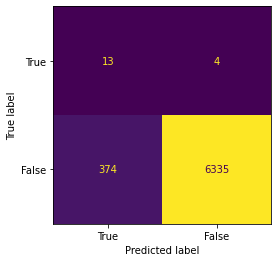

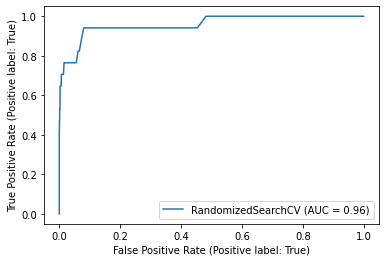

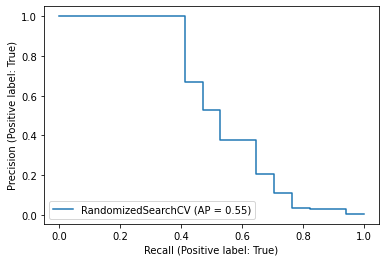

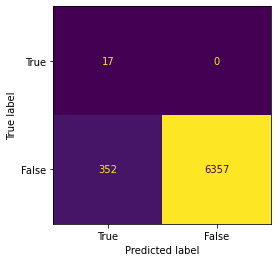

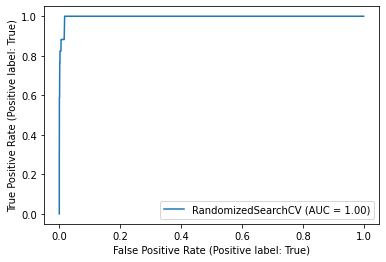

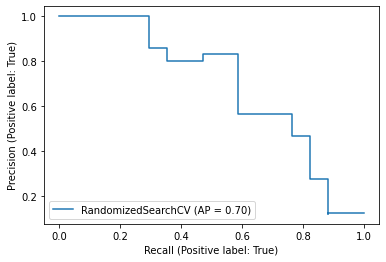

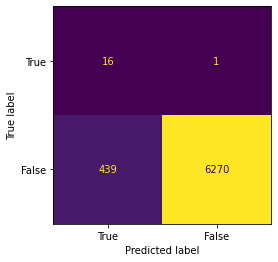

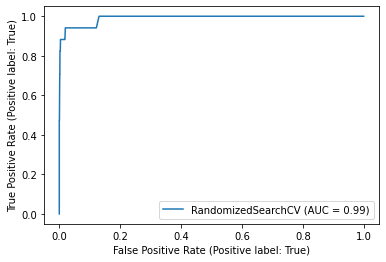

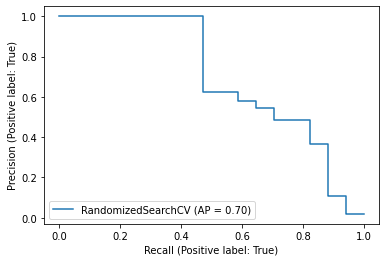

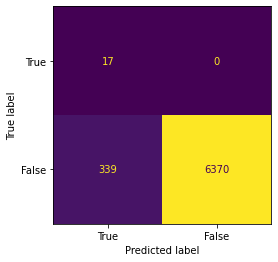

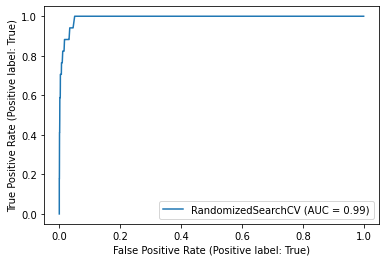

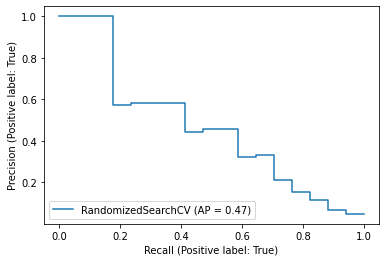

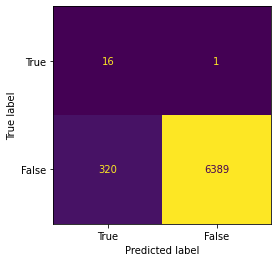

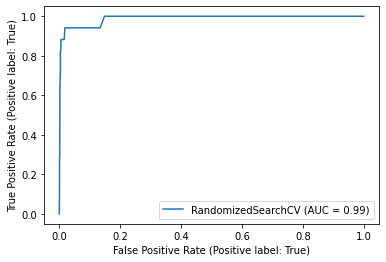

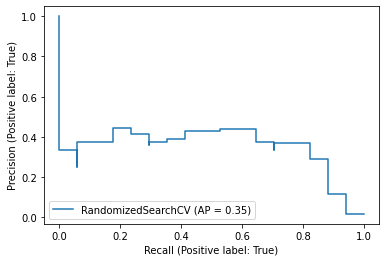

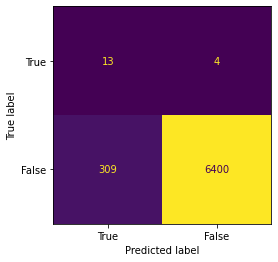

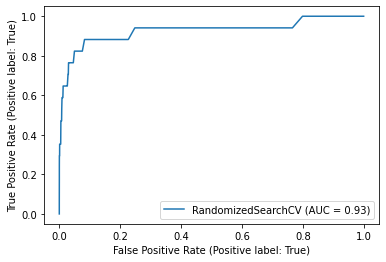

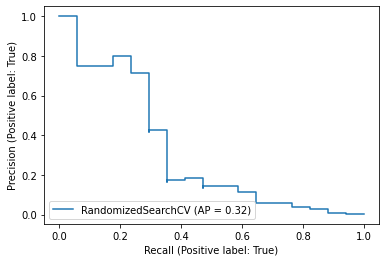

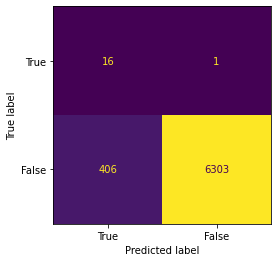

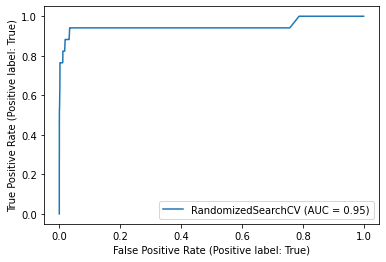

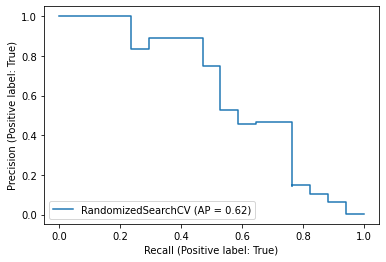

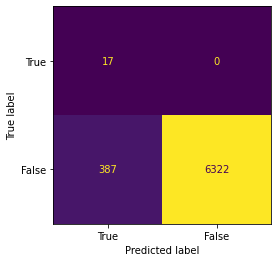

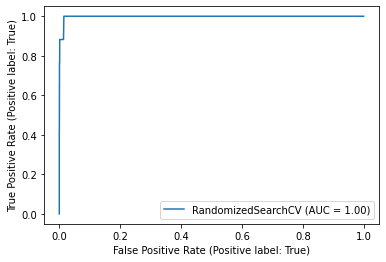

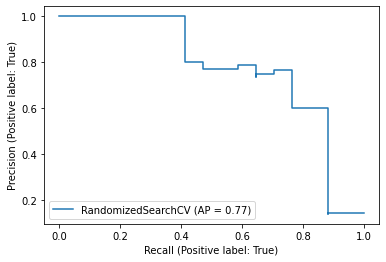

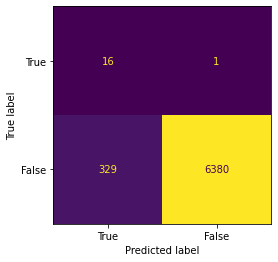

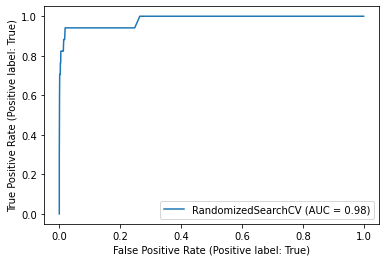

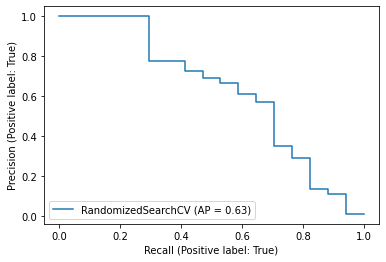

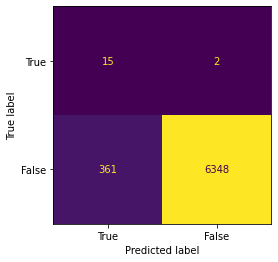

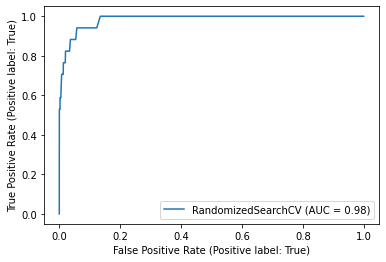

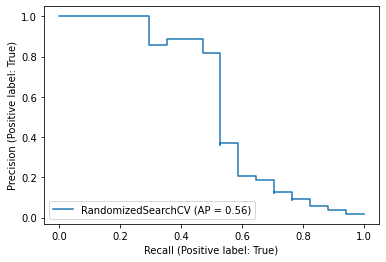

In [34]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier



for i in range(10):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    pipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                             #['under', RandomUnderSampler()],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    spaceEmpty = dict() 
    space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
    space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
    space['classifier__min_samples_split'] = [1, 2, 3]


    search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedRFModel = search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
          f"{elapsed_time:.3f} seconds")
    cv_score = optimizedRFModel.best_score_
    test_score = optimizedRFModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

ftwo_scorer = make_scorer(fbeta_score, beta=2)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sn_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]


LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66070896 0.66875803 0.65287922 0.67194323 0.66748363 0.63728285
 0.65829046 0.66980285 0.66823788 0.66139293 0.67586772 0.65797871
 0.66998482 0.67874691 0.63706016 0.6587514  0.67829593 0.66519413
 0.65709093 0.62452055 0.66525912 0.65907646 0.63954644 0.67292211
 0.63759632 0.68782238 0.65386919 0.64262675 0.66643661 0.67340641
        nan 0.6636696  0.64536707 0.66207126 0.67304271 0.66809325
 0.66411562 0.66347084 0.66405925 0.68277445        nan        nan
 0.70850293 0.66027197 0.7011431  0.67196178 0.6659179  0.65024421
 0.69160382 0.65648951 0.66129804 0.65530555 0.67656337 0.65759453
 0.64428579        nan 0.6609962  0.65180355 0.67845618 0.65973242
 0.67712406 0.66272166 0.66040839 0.66659973 0.67630799 0.65224701
 0.65640144 0.67196786        nan        nan 0.64349672        nan
 0.63782917 0.66300407

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 823.909 seconds
Cross-validation score: 0.7085029333191097
Test score: 0.42168674698795183
Best Hyperparameters: {'classifier__num_leaves': 26, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 700, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.6}
2569.5272483310036
1276.6614716475651
7474.538756780246
147.44615494912432
8.71322214823158
1.3915219213813543
0.6216594033758156
0.0
43.88744948152453
0.0
14923.976868411954
8.597509910992812
0.13108199834823608
0.0
31.842985122348182
0.0
0.32985475577879697
0.0
7.641203544102609
0.025456000119447708
14.299020290374756
13.976986379362643
0.13098500669002533
263.2693226051633
0.5521149933338165
0.000727317004930228
3.507319927215576
0.0
0.0
177.23335225030314
18.74914658988382
0.0
13.15808476224629
55.77246654911323
71.2204786189759
0.0
0.0
0.0
44.71841320551721


C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.59347365 0.59622858 0.5936966  0.59249449 0.63096427 0.592173
 0.60627343 0.59785133 0.58926201 0.61102837 0.60131291 0.57394225
 0.61294262        nan 0.62636858 0.59442038 0.62787272 0.62201417
 0.60041061 0.60585211 0.59278527 0.58246095 0.62196528 0.61451233
 0.59164985 0.59095584 0.60552686 0.66100321 0.62184069 0.59304215
 0.56751075 0.57956313        nan 0.58588691 0.62104442        nan
 0.57659048 0.57982863        nan 0.57751338 0.59245137 0.57464096
 0.57850663 0.60797921 0.59295724 0.58232031 0.5936463  0.60437271
 0.56981251 0.61194125 0.58340704 0.61905837 0.60261627 0.61503474
        nan 0.62631233 0.61294939 0.60373605 0.61937715 0.61020477
 0.56126799 0.58408444 0.6174381         nan 0.58229881 0.61917178
 0.61374333 0.58602171 0.59122659 0.60593853 0.59016088        nan
 0.59036889 0.61176754 0

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 875.777 seconds
Cross-validation score: 0.6610032124738008
Test score: 0.7865168539325842
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 900, 'classifier__max_bin': 100, 'classifier__learning_rate': 0.3}
1914.6869121905765
4477.594729000237
17794.720341720837
451.64015952499176
8.024317660718225
15.057884993031621
3.0948884151875973
1.1933264804829378
36.45706010470167
0.6244570016860962
21108.074610266543
0.6809097691439092
1.1499582172837108
0.0
10.73757093079621
0.0
135.3868888099969
0.0
0.762342884670943
0.034885363886132836
0.27700638957321644
0.27521447648177855
121.75884484295966
211.59795765858144
103.31244876980782
14.02180004119873
0.0
2.670712814986473
0.0
705.9060329105705
838.6311876000836
18.438697518780828
20.063986809742346
20.098380116236513
47.65

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.6139781  0.61269372        nan 0.6007074  0.61753361 0.62741616
        nan 0.6072694  0.63445348 0.63923611 0.62283656 0.63438123
 0.66199752 0.63010765 0.65281597        nan 0.6252069  0.56348594
 0.64221895 0.64941546 0.61938318        nan 0.64467173 0.63403956
 0.63843201 0.6038793  0.58960062 0.62853096 0.61980311        nan
 0.66201086 0.58218853 0.64079573 0.60504967 0.63281148 0.59000928
 0.60701978 0.61536307        nan 0.64716429        nan 0.61603141
 0.62295986 0.63015383 0.61133631 0.6307452  0.6236933  0.62036258
 0.63413304 0.57691691 0.64782497 0.60461551 0.64488945        nan
 0.61597362 0.60840717 0.62222472 0.60885332 0.62844927 0.62672468
 0.62731756 0.61797187 0.60647209        nan        nan 0.61567462
 0.62011538 0.62244733 0.62996395 0.61685285        nan 0.61620834
 0.63354364 0.64861424

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 844.419 seconds
Cross-validation score: 0.6620108588324907
Test score: 0.7303370786516854
Best Hyperparameters: {'classifier__num_leaves': 51, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 100, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.3}
2065.6482716492505
2473.9412578639044
39142.89362377327
296.77070356298196
51.74516212365627
3.3088656023722036
35.316329660295985
3.6248321625898825
0.09141777741528756
40.62278453687759
6796.82095819805
33.85078142864937
18.987734549795277
0.0
43.46531596227667
0.0
263.69993910359506
0.00047825800720602274
15.48094444596859
0.1570292678417886
13.727170005131
2.5704378515491024
5.212099506132255
183.88136021219134
0.6264675212613309
7.802455943354289
5.231691668605756
6.3845828103701985
1.1417292551659368
1183.8302326767123
92.56436252264811
6.300132108328749
10.

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.61035138 0.6499694  0.6416213  0.62124742 0.64263952 0.61536033
 0.59460494 0.64435193 0.63426511 0.59569803 0.59219775 0.61411646
 0.60939555 0.6174855         nan 0.63098562 0.61148305 0.6249478
 0.60768111        nan 0.65043666 0.60526534 0.61433834        nan
 0.62844396 0.62501266        nan 0.60988202 0.59258491 0.62226185
 0.62268732 0.63085591 0.62028251        nan 0.60565235 0.66336158
 0.62166851 0.60973791 0.63683866 0.62745465 0.59307413 0.63440678
 0.63406628 0.62106653 0.61431972 0.60625361 0.61598494 0.62877375
 0.59540244 0.62111331 0.62934277 0.62630328 0.60281978 0.63372575
        nan 0.61037797 0.60601432 0.63687538 0.64939496 0.6125075
 0.61131067 0.59692234 0.61632652 0.61281323 0.62828207 0.64986731
 0.61456625 0.61452054 0.62775099        nan 0.59453943        nan
 0.61346899 0.61143429 0

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 849.442 seconds
Cross-validation score: 0.6633615769489134
Test score: 0.7142857142857143
Best Hyperparameters: {'classifier__num_leaves': 11, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 100, 'classifier__max_bin': 50, 'classifier__learning_rate': 0.4}
3318.3076675673947
1068.9475701348856
23840.594230391784
2114.4938564784825
36.96173846721649
0.7731362879276276
27.62350661866367
0.00995889026671648
0.0
0.6050300002098083
8032.340840297751
181.3744505699724
191.42533719539642
0.0
27.20275839162059
0.0
152.28701758384705
0.0
0.047837600111961365
0.09029960073530674
4.466779857873917
29.46274631493725
82.8640261106193
56.78604280948639
19.946815848350525
0.0
0.005965719930827618
53.06875622831285
0.03715920075774193
1314.7654319251888
5.126405677758157
1.1271715089678764
9.617127023404464
175.00290380441584
430.38

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.61601373 0.63507915 0.55213617 0.57132048 0.59027767
 0.60413936 0.6101075  0.60005628 0.60258113 0.56614614 0.61860188
 0.58663251 0.62616924 0.61846638 0.60723585 0.63981412 0.61997665
        nan 0.55572525 0.60806881        nan 0.59890678 0.57370201
 0.57432033 0.59381003 0.59551094 0.57813695 0.53325998 0.61860816
 0.61038589        nan 0.6108566  0.61331153 0.58502692 0.57608793
 0.60670165 0.55622784 0.6140257  0.62329121 0.57257582 0.57513939
 0.57764997 0.54504645        nan 0.58000432 0.62021715 0.53619916
 0.58771564 0.57596698 0.5936355  0.58601612 0.55789309        nan
        nan 0.61634272 0.60744103 0.60671163 0.63254342 0.62309409
 0.59321685 0.57506977 0.58502364 0.55709669 0.5896714  0.61168521
 0.61178192 0.60802751 0.58777934 0.6193793  0.62352573 0.58529309
 0.57696988 0.63433818

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 862.663 seconds
Cross-validation score: 0.6398141236860277
Test score: 0.7954545454545455
Best Hyperparameters: {'classifier__num_leaves': 11, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 800, 'classifier__max_bin': 200, 'classifier__learning_rate': 0.2}
7978.191399157047
3257.6424384638667
14470.896840438247
4027.0477956160903
50.570833802223206
0.0
27.181391775608063
0.0
0.0
6.708661451935768
35526.779768653214
157.41892063617706
20.4574975669384
0.0
16.610674791038036
0.0
0.3672730028629303
3.020699977874756
6.682229995727539
4.849321961402893
7.9875220358371735
15.870076835155487
0.9721110165119171
217.24340057373047
141.57986640930176
2.4878599643707275
0.0
0.26903900504112244
0.1685519963502884
854.0268424749374
34.582200050354004
1.01807801425457
10.389518111944199
295.11210983991623
333.84195939451456
0.0


C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62750762 0.62695552 0.64465649 0.59475426 0.66128405 0.6385067
 0.65092723 0.60776326 0.6473362  0.65929431 0.65504562 0.67736484
 0.63989598        nan 0.65102759 0.62501347 0.63988145 0.65992374
 0.63093959 0.61187931 0.62059152 0.6055623  0.61231992 0.654792
 0.65865945 0.61656724 0.60855713 0.67475816 0.64132587 0.64097954
 0.64051477 0.63177874 0.60988402 0.61399898 0.60400864 0.6445135
 0.64842052 0.6540748  0.62023116 0.67878151 0.65888683 0.6566647
 0.62350381 0.60909091 0.64513671        nan 0.63579976 0.6171903
 0.65201439 0.66796508 0.67161673 0.67121791 0.62782835 0.67655055
 0.63581236 0.60490723 0.65404969 0.64050415 0.63507409 0.60386125
 0.62115065 0.62500471 0.6858624  0.61909694 0.61959983 0.65140073
 0.63179752 0.6539534  0.62906072 0.65162989 0.62768801 0.62533153
        nan 0.65138117 0.612

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 901.275 seconds
Cross-validation score: 0.7047397574487357
Test score: 0.625
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': -1, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.1}
18107.32679763064
7050.296537870225
24378.09891143395
1380.2658645792508
15.271063311241733
18.047798582105216
15.862183003784594
3.2494099140167236
25.86434181034565
4.157259941101074
65961.76144304131
52.25284066790712
16.516560316085815
0.0
152.32469812385898
0.0
340.62212942291853
0.6418970227241516
4.963352730129344
5.253370129675318
43.40345357998922
10.87398146013129
0.7947874098702314
516.6559782693269
108.40010154247284
16.88596953541736
3.76568182142114
7.303095331970553
2.1943498145087688
1861.8103908713902
307.372017700317
16.517280435817767
227.54272702594244
109.0

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64610599 0.64709086 0.63603624 0.6189278  0.62895948 0.68610435
 0.6383305  0.64223498 0.6097533  0.64520181 0.62468499 0.65833918
 0.62938756 0.61598027 0.63308019 0.65250634 0.63958349 0.63656034
 0.61270533 0.65968245        nan 0.66459004 0.62418612 0.66518709
 0.6489231  0.6493716  0.63181891 0.62013409 0.63315327 0.65250914
 0.64436979 0.646526   0.62352238 0.63227714 0.65989678 0.63958529
 0.67239957 0.65824482 0.62926744        nan 0.67050601 0.61657223
 0.63258185 0.64337026 0.63850614 0.63596797 0.65650052 0.63551949
 0.64808282 0.6476453  0.67122914 0.6217977  0.63555275 0.62642191
 0.6543611  0.61899936 0.64973076        nan 0.61367323 0.60543231
 0.6231238  0.64195932 0.65498068        nan 0.65469225 0.63145973
 0.65135604 0.64668563        nan 0.64625405 0.65992063 0.61111627
 0.62456234 0.60049718

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
Elapsed time to compute best fit: 902.970 seconds
Cross-validation score: 0.6861043452058517
Test score: 0.7317073170731708
Best Hyperparameters: {'classifier__num_leaves': 26, 'classifier__min_data_in_leaf': 200, 'classifier__max_depth': 200, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.4}
3472.12466358074
5088.976638043794
7192.239663576085
830.3900957787373
5.214432092296192
3.818378247480723
7.9693960003132815
0.004929369781166315
19.526663485972676
1.454200029373169
23543.090430441
0.0006166460225358605
38.30654001235962
0.0
9.3205757746764
0.0
18.09981388610322
0.008532157575245947
0.07332242885604501
1.793239951133728
1.6326270513236523
3.438704546773806
75.67976303629075
72.9823294878006
11.795416278298944
0.0
0.001185150002129376
7.158840179443359
0.0
231.4997068331577
0.9794337470084429
0.1828904957510531
5.754563932743622
121.5803950235640

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.62493958 0.66386261 0.60739231 0.61861662 0.63821261 0.67375056
 0.64040147 0.63300931 0.6345906  0.62571539        nan 0.57996985
 0.5888938  0.61662972 0.62259186 0.60945928 0.64378273 0.61152207
 0.60274189        nan 0.63502832        nan 0.59118641 0.63240495
 0.63383174 0.6230247  0.6301962  0.63212446 0.62683594 0.6159149
 0.60922933 0.62381428 0.61506329 0.6370535  0.63174985 0.61289902
 0

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 856.547 seconds
Cross-validation score: 0.6737505643755644
Test score: 0.6896551724137931
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 400, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.4}
5457.343302166148
3158.2063709926733
7076.1673390479355
775.9012148857582
45.07424195672502
9.376171133219032
5.173157347366214
0.19980058167129755
12.711921794572845
0.0
19987.80589167695
3.6559151597321033
2.975024089217186
0.0
30.016289538121782
0.0
115.09443610208109
0.0
1.112362202256918
26.87623686520965
0.4941129069775343
7.068681710312376
2.9179354747757316
807.542070388794
0.0064049900975078344
292.3690028190613
1.0017817839980125
0.42976900935173035
0.06300540268421173
1122.0924551344651
12.322511428596044
103.85738506168127
21.295308909378946
189.410068

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.60863794 0.56964147        nan 0.59704583 0.56152075 0.63266172
 0.61729214 0.57077519 0.6203997  0.61519232 0.59658389 0.57271162
 0.58250524 0.5390995  0.56352268 0.57952759 0.63736461        nan
 0.6316604  0.58587657 0.6241586  0.56032536 0.61705762 0.56027648
 0.60892321        nan 0.59334858 0.53150835 0.59498569 0.57913737
 0.60223221 0.60433311 0.58470161 0.5568855  0.6218654  0.61241048
        nan 0.56604846 0.60120909 0.61775643        nan        nan
 0.61681109 0.59744969 0.52602653 0.61820476 0.62535734 0.60545723
 0.56869447 0.59333126        nan 0.63518066 0.60700814 0.59228625
 0.58606141 0.54663564 0.56298454 0.6025207  0.64090967 0.59241461
 0.5641398  0.5999313  0.57682237 0.62401251 0.51442374 0.62263584
 0.61970382 0.60470867        nan 0.57434375 0.59374724 0.61308349
 0.59280797 0.59002122

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 820.300 seconds
Cross-validation score: 0.6409096679607516
Test score: 0.7386363636363636
Best Hyperparameters: {'classifier__num_leaves': 11, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 600, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.5}
2951.522863451988
1752.967046555772
9962.057497622809
588.8256704786036
1.1886224509216845
56.58730353182182
43.19245476904325
0.02102229930460453
0.7406988910224754
0.5942950248718262
16646.33290101304
2.339716943766689
4.147454662015662
0.0
14.384544752538204
0.0
64.42874784744345
0.0007463879883289337
11.665104180225171
3.165879562497139
0.0
11.261617760930676
0.0034886898938566446
107.74941017478704
20.491893040016294
2.190084026195109
5.656001043273136
0.0022252399940043688
1.213095283077564
438.86424548365176
8.601926293689758
5.259158842498437
10.2067148157

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68518763 0.65400036 0.68016371 0.65615303 0.68088829 0.67864033
 0.6766691         nan 0.67525465        nan 0.66525055 0.67246047
 0.67069812 0.6337288  0.65162363 0.67874055 0.67297947 0.69604817
 0.66934578 0.66757009 0.63980853 0.63030134 0.64811129 0.65308188
 0.66190441 0.65092981 0.6473735  0.66465969 0.70035284 0.66502813
 0.70089572 0.66950729 0.68249535 0.65549828 0.66532565 0.63177617
        nan 0.64851955 0.65081583 0.66130675 0.67301523 0.682806
 0.66069848 0.66689107 0.6852664  0.66677617 0.65784939 0.67950873
 0.68996382 0.68838384 0.65607107 0.66796339 0.672383          nan
 0.64740426 0.62700199 0.68630329 0.65263435 0.69135014 0.69534471
        nan 0.64686545 0.6488323  0.67999811 0.65974589 0.64282559
 0.66361841 0.68162091 0.65675276 0.66406358 0.64160814 0.67348302
 0.64690913 0.66135456 0

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 890.303 seconds
Cross-validation score: 0.7076340500489107
Test score: 0.632183908045977
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 300, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.1}
6196.437051194846
10810.659758036156
71856.14088786511
7200.032016114005
13.479961020039468
50.92518157107064
45.10083847532928
0.0
18.41594203014847
0.0021908499766141176
36163.37922551766
36.00325674685871
42.43988034315407
0.0
21.710771505535263
0.0
16.05414995605679
9.960693755268949
197.00266179140672
12.071499834305996
1.9787403737435199
13.41696827847045
188.9608219456486
184.76123391666988
347.3776027993299
6.637195652027003
10.288119546077723
12.197484214302676
103.37200012383983
1112.9332505848047
80.31446073241392
15.847601417251553
41.13132892349813
100

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66170988 0.68790047 0.66074852 0.68784058 0.67846091 0.68692772
 0.69184823 0.6907312  0.68334018 0.69035661 0.66548173 0.70702212
 0.62764082 0.72489867 0.71832928 0.6690042  0.64349221 0.63356258
 0.63349499 0.68475992 0.67316526 0.67038574 0.71243878 0.70969834
        nan 0.62771463        nan 0.66797309 0.67738739 0.65417513
 0.64650201 0.63568764 0.65394851 0.67677804 0.652853   0.63251188
 0.6619289  0.69121081 0.66325446 0.68007479 0.6840303  0.67967858
        nan 0.68946461 0.71023767 0.65197242 0.66875057 0.70391214
        nan        nan 0.66377597 0.71546077 0.68872663 0.63207374
 0.66813381        nan 0.66508043 0.64323676 0.71208793 0.66347885
 0.66867555 0.66716915 0.63399448 0.65350177 0.71337252 0.68851092
 0.65319766 0.70524182 0.68600726 0.68817631 0.66948758 0.70248032
 0.66266927 0.70116972

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 903.796 seconds
Cross-validation score: 0.7248986749949522
Test score: 0.6470588235294119
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 500, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.1}
10997.768745349487
3796.324318913743
75838.26969552733
12478.838454522192
45.75091131031513
15.518985092639923
42.95351028442383
0.0
8.751978099346161
1.9559400081634521
33839.41156703187
46.18353492021561
42.01572246477008
0.0
33.73785984516144
0.0
6.313098967075348
11.125199913978577
50.37337923049927
10.298866927623749
3.6887310445308685
13.462999820709229
12.09693906456232
157.30944204330444
110.40252029895782
6.690153151750565
7.91366982460022
1705.6577787101269
149.3524285554886
1530.4339201301336
62.68311765789986
84.6158390045166
49.888875871896744
24.1329

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64034991 0.63871734 0.60345499 0.54522207 0.64196127        nan
 0.64992706 0.5602608  0.56537768 0.56761048 0.59258397 0.62250359
 0.57118154 0.65163246 0.64573832 0.6310538  0.635628   0.6334386
 0.61337315 0.62381244 0.59430075        nan 0.56697565 0.64783923
        nan 0.60128225 0.59350549 0.58211578 0.66198767 0.64326478
 0.62432838 0.60842962 0.58137636 0.64426328 0.58871894 0.66869072
 0.60165733 0.60582599 0.57792895 0.61462232        nan        nan
 0.63892471 0.59468101 0.59867408 0.57916832 0.58394948 0.63544747
 0.61128072 0.61117841 0.58348661 0.63819485 0.65596792 0.63230913
 0.605938   0.60167703 0.61397235 0.62406486 0.60315854        nan
        nan        nan 0.63555993 0.60378709        nan 0.67228296
 0.62586506 0.64612286 0.60164763        nan        nan 0.63127878
 0.63884213 0.64242935 

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 863.045 seconds
Cross-validation score: 0.6722829581188714
Test score: 0.7303370786516854
Best Hyperparameters: {'classifier__num_leaves': 51, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 800, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.1}
21933.18032464175
6118.095348965656
36188.678556617044
5073.8611093080945
33.47126788181993
11.502206678724633
43.12723004817963
0.0
12.236200332641602
1.0797100067138672
61598.47388151195
52.707165547477416
13.19320564539521
0.0
62.17945051438795
0.0
127.55655348712571
0.33547387446742505
17.83511463438117
23.234765391417056
57.14164208346904
172.92002442502417
79.32452980056405
325.8143362250048
17.770299069241446
0.0024197255480089552
0.015452751133125275
90.21325943213867
4.173675800033379
1959.5594669829516
1202.3671263119322
0.08759958839800674
532.394738870

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68029839 0.65737547 0.6605266         nan 0.66760036 0.6844541
 0.67403942 0.65587497        nan 0.64349321 0.66604002 0.68029152
 0.67120237        nan 0.65709863 0.6599485  0.70702673 0.68271463
 0.70199908        nan 0.68007912 0.68435728 0.64304324 0.70138813
 0.67730309 0.66273265 0.64053822 0.68593704 0.6629126  0.66500771
 0.67026819 0.64108261        nan 0.65026837 0.66225754 0.64666999
 0.69001609        nan 0.68342529 0.65172134 0.66941189        nan
 0.63882622 0.66686631 0.64945162 0.6461622  0.67335949 0.68657305
 0.64608089 0.64180722 0.6717437  0.67190391 0.70984049 0.69324755
 0.66205799 0.69323672 0.68483964        nan 0.67717782 0.68825111
 0.6349831  0.6879529  0.65438019 0.68144335 0.68177957 0.67124589
 0.6398233  0.6470608  0.66182871 0.6650391  0.70988481 0.65573126
 0.69384909 0.68921858 

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 853.592 seconds
Cross-validation score: 0.7098848119358955
Test score: 0.44871794871794873
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 600, 'classifier__max_bin': 200, 'classifier__learning_rate': 0.2}
6243.943410409614
1533.8733778484166
52444.36292076111
399.7910064458847
12.9093649238348
0.022854400798678398
0.037541601806879044
17.0964413061738
43.46645885705948
3.179149854928255
11653.89085817337
0.5054791122674942
34.65600047074258
0.0
15.499453499913216
0.0
11.300070226192474
21.705344818532467
0.0
0.7958850264549255
48.63904222659767
0.756610170006752
24.062116503715515
151.54813209176064
0.0
0.03886429965496063
0.8583400249481201
2.0046239644289017
0.03261759877204895
598.8730675987899
44.46208316460252
5.175149992108345
8.3873807862401
332.10583815351

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.60099529 0.63744728 0.6204533  0.62185456 0.5912528         nan
 0.59730254 0.60947993 0.56422063 0.61419315 0.63994715 0.6090978
 0.58772227 0.58914033 0.60911609 0.59627388 0.58293767 0.59389058
 0.6168006  0.62658027 0.6512367  0.57801744 0.60999658 0.61396252
 0.60094579 0.57443623 0.62476008        nan 0.64666589 0.64223498
 0.57362216        nan 0.61350717 0.61278129 0.58726765 0.61889736
 0.60643977        nan 0.61287052 0.55872565 0.63189419 0.61336486
 0.58705299 0.63802947 0.60316592 0.61974468 0.60273852 0.5824847
 0.60416736 0.64956805 0.64088298        nan 0.60694082 0.60723694
 0.61866144 0.62794927 0.62163421 0.60329585 0.62197996 0.59977028
 0.59000304 0.62683415 0.64765133 0.61896123 0.63201271 0.61397989
 0.58917648 0.61986255 0.60656988 0.65017892 0.59797183        nan
        nan 0.61144961 0

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 869.735 seconds
Cross-validation score: 0.6512367008206791
Test score: 0.6707317073170732
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 400, 'classifier__max_bin': 500, 'classifier__learning_rate': 1.0}
3822.5804153480585
305.2642910279337
3583.7582691873667
3077.5459523419995
3.8749651396647096
2.9252658449079263
1.452635020017624
0.0
0.5317751988768578
0.0
11723.705136282795
63.46724546211772
14.17528934776783
0.0
4.678618336240836
0.0
2.752542034970247
0.0
0.7416727878153324
0.4226015744947631
0.00022075300512369722
5.962459908914752e-06
0.08943868029746227
4.261619778844761e-06
1.3396999747783411e-05
0.04470270127058029
0.062346116660023654
0.026353719264790243
0.10685285614256168
679.9949457058683
2.207468418460081
2.851369941781223
3.247405366439141
36.5108

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.65487127 0.6722349  0.65221806 0.68146308 0.64818229 0.67340948
 0.67044195 0.67796334 0.67459051 0.65657115 0.64167486 0.64063959
 0.66061321 0.65862579 0.6742288  0.68597094 0.67109363 0.60988973
 0.66954313 0.67518009        nan 0.65932149 0.6498334  0.67063678
 0.6627491  0.66389123 0.68462569 0.67353847 0.66420475 0.67572599
 0.67033832 0.65779537 0.66307321 0.64186228 0.64460735 0.67157593
 0.62819583 0.62536958 0.67644758 0.62572615        nan 0.65192047
 0.68019196 0.66164278 0.66197092 0.67272218 0.66011355 0.70130885
 0.69280004 0.65351135 0.64449458 0.65561827 0.65908055 0.69597471
 0.69544321 0.70228628 0.6835874         nan 0.67816537 0.65298705
        nan 0.66815023 0.67467728 0.64241344 0.6926507  0.6561564
 0.67201242 0.68163437 0.63561626 0.65720978 0.64677092 0.65277427
 0.65003771 0.65469129 

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 834.749 seconds
Cross-validation score: 0.7022862755310573
Test score: 0.5882352941176471
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 900, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.4}
3375.6570648496563
969.5823481391344
28985.779300512375
331.599992478441
2.0433113632025197
7.293645052748616
14.342533706309041
0.9501105244125938
24.025719046592712
0.038615599274635315
7815.191333316776
0.0
141.81400440470316
0.0
3.196399977139663
0.0
76.46494612842798
0.0
0.005869640037417412
1.7332700490951538
0.041145617258735
0.30639391962904483
29.19289987994125
87.53175264550373
0.019836900755763054
0.040347300469875336
1.4376976396888494
10.855067603290081
0.0016453549906145781
33.16088826395571
75.88527819259616
2.9555739839270245
0.7867987645731773
22.

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.7352366  0.66360591 0.69675734 0.73400341 0.71922658 0.68865427
 0.69372316 0.68102756 0.68409285 0.65479454 0.66150934        nan
 0.70653913        nan 0.67308957 0.67259947 0.6717154  0.67611336
 0.6851148  0.6985081  0.70985115        nan 0.71694817 0.70636176
 0.66709858 0.73353753        nan 0.69329456 0.73793569 0.71167277
 0.71851494        nan 0.69924211 0.70156162        nan 0.68473195
 0.73536236 0.6931564  0.70571043 0.6995125  0.67492567 0.69585764
        nan 0.70810113 0.64848738 0.68025281 0.69516276 0.70766038
 0.70288462 0.68746703 0.70946564 0.72115305 0.6996421         nan
 0.66106695 0.70226371 0.6913681  0.72938312 0.69061601        nan
 0.72010195 0.67118241 0.6935274  0.72587715 0.70281065        nan
        nan 0.71534711 0.71744953 0.70015564 0.65360215 0.70246153
 0.67355767        nan

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 777.976 seconds
Cross-validation score: 0.7379356922540439
Test score: 0.47619047619047616
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 300, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.2}
10370.140257155015
2426.881806295711
19255.775780328866
318.4712741177717
7.433492885281877
3.8709025048467645
24.009457542560995
0.0
8.049479947658256e-05
0.14154300093650818
32956.53221469602
41.821166005311795
25.534473406386724
0.0
59.87428356050605
0.0
62.60037075344803
0.0010789720108732581
43.57525190233982
2.2359346390185237
18.753068510001658
91.63887813471956
56.793258754005166
500.84338154788065
0.3815087162074633
0.0010349152071285062
0.18569391456276207
4.51695654113405
0.0
706.4412308193096
349.4790242243671
24.2374144313027
2.3907599722655926
821.5

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.65327414 0.65294409 0.67101467 0.66077871 0.70043626
 0.65435991 0.67417738 0.67764132 0.66036166 0.66555914 0.66737571
 0.68133592 0.67393574 0.68854741 0.65756586 0.6525269  0.65957561
        nan 0.66435591 0.68493947 0.66579277 0.69138815 0.6242613
 0.69882183 0.64371139 0.66559006 0.65252417 0.65721778 0.65989219
 0.66770559 0.66124851 0.67923871 0.67330722        nan 0.69210094
        nan 0.64323601 0.6535332         nan 0.64351258 0.6649159
 0.66705891 0.67598051        nan 0.68562722 0.68375422 0.67168926
 0.68199064 0.68102639        nan 0.69814798 0.67268828 0.64659213
 0.66711928 0.64839143 0.68806977 0.7000794  0.71047564 0.6849469
        nan 0.67267616 0.6677171  0.68163921 0.67541805 0.66828008
 0.65245395 0.6429814  0.69021863 0.67510419 0.70870077 0.68643097
 0.69364462 0.67781694 0.

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 820.804 seconds
Cross-validation score: 0.7104756398874045
Test score: 0.6818181818181818
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 800, 'classifier__max_bin': 50, 'classifier__learning_rate': 0.4}
6152.168268720233
935.373164673054
13649.997188331203
547.4023931107994
16.537926208051374
65.1726280776783
1.020032363710925
0.6153802557382733
8.023640301427804
0.004283070098608732
16722.08706258068
101.61368559677365
16.263327550084796
0.0
47.78330084632677
0.0
39.535152071446646
7.724660235908232e-07
2.8069004659482744
0.03478885078220628
1.4222008947890572
0.01417692013599936
0.965478371831793
413.1034728240593
2.4344672083389014
50.82162870100001
0.5424181407397555
0.2821242552899861
95.22816789150238
933.5937467343938
3.96606230980251
3.0117419076570306
80.

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64495795 0.60892435 0.64106166 0.64041318 0.63062398 0.63845997
        nan 0.63276522        nan 0.63234706 0.63848669 0.60559832
 0.59688309 0.64429464 0.6435116  0.60924907 0.64000783 0.63729889
 0.62006908 0.63253827 0.64485734 0.62663052 0.64984029 0.63814516
 0.62187474 0.6428249         nan 0.63819443 0.61318259 0.6256157
 0.62147899 0.65960231        nan 0.64547425 0.65789057 0.64016223
 0.66300969 0.60416567 0.62377387 0.61639535 0.60926151 0.61383906
 0.63351551 0.62341906 0.62809213 0.63951734 0.62552013 0.62278147
 0.62883498 0.64441126 0.63627451 0.62769283 0.62476942 0.6206597
 0.64729933 0.61144451 0.6438191  0.6285472  0.63490757 0.62063951
 0.60750698 0.63934584 0.66462594 0.64321428 0.63908923 0.62891873
 0.59048061 0.65300625 0.65423706        nan        nan 0.6506241
 0.65248025        nan 0.

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 796.302 seconds
Cross-validation score: 0.6646259382591785
Test score: 0.6593406593406593
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 600, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.1}
12128.859769642353
2593.7881084680557
86782.82886949182
7314.19738599658
135.38849633932114
43.06691002845764
1.0284199714660645
3.5174999237060547
32.71765971183777
0.0
22059.445562422276
1.4527100324630737
0.0
0.0
8.80478984117508
0.0
25.407714169472456
0.0
2.062245672568679
4.287820100784302
312.8600654602051
128.950909614563
3.7069010138511658
567.7628240585327
16.711542904376984
5.912099838256836
0.0
2.190850019454956
2.0644099712371826
5134.704593062401
1133.6839594841003
10.333230018615723
53.59788978099823
482.9529422521591
207.24359606206417
0.0
0.0
0.0
3

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.59494313 0.62398765 0.65661156 0.61200697 0.61000216 0.64935047
 0.62229049 0.64663867 0.59551069        nan 0.62188483 0.6151455
 0.60547141 0.63811991 0.61681571 0.63766381 0.63229912        nan
 0.64688494 0.61121959 0.62658656 0.64357768 0.57762212 0.62754047
 0.61351151 0.6544689  0.6005142  0.59053079 0.61314979 0.63742661
 0.64376275 0.62483934 0.59231045        nan 0.63615466 0.64498406
 0.62891928 0.60343146 0.62728333 0.64139767 0.61540369 0.60198864
 0.62132394 0.66328226 0.61719104 0.63493711 0.5916381  0.62044936
 0.60159176 0.63083815 0.63172773 0.61509538        nan 0.66886397
 0.59134426 0.63885078 0.63988674 0.638711          nan 0.60066993
 0.63727681 0.6614634  0.64585791 0.61849662        nan 0.64613495
 0.6279815  0.59716973 0.63526986 0.64480733 0.58381965 0.63968098
 0.64848946 0.62925196 

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 900.865 seconds
Cross-validation score: 0.6688639675772029
Test score: 0.7558139534883721
Best Hyperparameters: {'classifier__num_leaves': 11, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 700, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.9}
3653.440237494986
1306.2401104126147
1949.8968249021473
58.85355118892767
2.1808596586051863
2.4740101340576075
81.35400718450546
0.0034378499258309603
0.0
0.08396530151367188
10741.987157417752
8.795517508959165
0.13492999970912933
0.0
1.0976357699837536
0.0
0.09037110209465027
0.0
0.0
6.26840603351593
0.004509249934926629
31.76470634672296
1.0546599626541138
340.6690139770508
5.562824254855514
1.1553800106048584
0.8051599860191345
2.4653799533843994
0.5886465888470411
327.38226502240286
99.35925979899548
17.06920051574707
11.71013707765087
24.41720123661071
23.1

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.64055803 0.67374011 0.6917419  0.67516328 0.70062501 0.72167343
 0.71305483 0.72001388 0.68309679 0.6593353  0.68559853 0.67204435
 0.71210591 0.70238267 0.68774276        nan 0.73578302 0.7178109
 0.7116214  0.73333208 0.70673366 0.68444104 0.70565895 0.68479203
 0.68417289 0.68508872 0.70132859 0.69645711 0.68882115 0.66977901
 0.62543057 0.68086226 0.68713254 0.71313922 0.71927489 0.63936942
        nan 0.66906575 0.71048905 0.70009052 0.63495915 0.65780573
 0.7187317  0.70643083 0.73476104 0.70169261 0.71284659        nan
 0.70887626 0.70598058 0.69748034 0.69283055        nan 0.68208231
 0.6891586  0.66565366 0.6905616  0.71410143 0.70886433 0.66857594
 0.70303409 0.69966955 0.70929369 0.65391217 0.69265282 0.67170087
 0.68639303 0.67452803 0.70322917 0.68099943 0.66990782 0.67515164
 0.69129285 0.74220736 

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 877.392 seconds
Cross-validation score: 0.7422073631950792
Test score: 0.4430379746835443
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 600, 'classifier__max_bin': 150, 'classifier__learning_rate': 0.1}
4636.218825717268
13775.784206687067
95197.9018684452
6089.745890533836
72.05960237364525
32.25184805839672
193.41093452554196
0.1962530016899109
5.5448908221524675
0.0
21908.432954411433
32.22257905240258
69.66671012231382
0.0
41.48796140507329
0.0
17.10631097786245
0.2995743118226528
83.25791731989011
75.36835661693476
55.76037469506264
54.106590899507864
7.298935091122985
486.8354751765728
52.14818182401359
1.837977654999122
1.3924918202692425
3.4317905923817307
2.6204364733566763
2461.7989672765834
196.95907515031286
13.718964009545743
16.589611175761092
155.6

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.63747185 0.63041661 0.64140536 0.5799331  0.64195838 0.63670687
 0.62798999 0.62708421 0.61428245 0.60744886 0.64045611 0.61177841
 0.63688412 0.6044018  0.60944444 0.60324284 0.61521466 0.60900827
 0.61999987 0.63672309 0.62881949 0.64708425 0.62754723 0.59952287
 0.59953739 0.66053666 0.63203318 0.61706793 0.63763402 0.61604141
 0.63535618 0.61227519 0.61653193 0.59972618 0.62856051 0.61826308
 0.60323405        nan 0.6236226  0.58885215 0.63456009 0.65218272
 0.65703613        nan 0.62695752 0.57232156 0.62588724 0.64361431
 0.58777934 0.61833926        nan 0.62052637 0.61870026 0.61872757
 0.63909962 0.64077034 0.61021216 0.63529394 0.64130384 0.64095641
 0.61573789 0.62352442 0.62042936 0.6038752  0.6094703  0.6260748
 0.61672562 0.61304315 0.64487916 0.6105682  0.61606582 0.63479037
 0.59426972 0.62559154 

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 892.450 seconds
Cross-validation score: 0.6605366634778399
Test score: 0.6666666666666666
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': -1, 'classifier__max_bin': 500, 'classifier__learning_rate': 0.5}
3989.774530391224
767.7995463005934
19699.903350483426
403.84073846408137
1.4749485373467905
6.37058826602879
0.5387580022215843
0.0008543350268155336
1.8649363111617276
10.169084091670811
7313.83010517068
0.6978271050247713
0.00013750999642070383
0.0
207.92855561175384
0.0
4.927014432606967
0.06260751068522818
10.23233356705714
0.003087214077822864
2.113260684418492
4.238475811391254
60.36643471714342
12.791368344720922
5.144424609355099
0.0014256699942052364
0.5785643525295497
2.5698845995900896
0.030858343583531678
1019.7073901133957
23.202258958481252
0.1387177

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.58940185 0.61685408 0.61289887 0.59786784 0.60402989 0.60727663
 0.62419537 0.57249945 0.60212349 0.59935638 0.60185754 0.61361596
 0.58888289 0.62078908 0.58889527 0.64815844 0.63015171 0.60364007
 0.59375805 0.58868049 0.60358011 0.57265546 0.58672157 0.61602617
        nan 0.6281646         nan        nan 0.63609936 0.60233556
        nan        nan 0.63280595 0.5818529  0.59890788 0.58334019
 0.59259391 0.60468904 0.59816372 0.60504197 0.61005556 0.59834091
 0.58712093 0.61964253 0.60505968 0.60806752 0.57953443        nan
 0.58279545 0.6299778  0.62501766        nan 0.61286811 0.59345854
 0.5938059  0.60413228 0.58543276        nan        nan 0.60272957
 0.62276666 0.59416871 0.59425453 0.5733036  0.59240531 0.60746213
 0.60210373 0.62663462 0.62803298 0.63105472 0.60511573        nan
 0.59039902 0.58959171

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 837.438 seconds
Cross-validation score: 0.6492421194398279
Test score: 0.7446808510638296
Best Hyperparameters: {'classifier__num_leaves': 51, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 200, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.5}
2621.4657713384536
1398.892907556071
18901.69436460109
2184.4252492902633
8.188219578842219
8.815067147959313
18.091928221983835
0.5738475506732357
0.03144159913063049
1.416990041732788
8471.133861530478
12.191238393858363
10.645165184279904
0.0
104.90854972854702
0.0
24.961650601839576
0.0
6.113761770547724
0.06789690001824056
1.3823208189438958
31.87691277407197
6.655336171141165
70.74575816967577
2.9544821648414654
5.894101188503829
1.253845157527394
54.55823609412962
0.0
258.73058975828394
36.92566107231899
0.6617476998790153
14.991495351784105
28.793833927656

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.65403384 0.63579695 0.59263979 0.60491582        nan 0.62648526
 0.63230878        nan 0.64022973 0.61153977 0.59447104 0.59889613
 0.63524112 0.56803682 0.61155755 0.58497582 0.57884385 0.6341018
 0.6198589  0.63696262 0.60654358 0.5947804         nan        nan
 0.62012278 0.59317956 0.59346743 0.61058107 0.59715397 0.64955541
 0.60801202 0.61682627 0.63074355 0.59283399 0.6580371  0.61295272
 0.66071783 0.63023176 0.64423857 0.63167501 0.58772572 0.60099973
 0.6019946  0.58782206 0.55829397 0.42969624 0.61550743 0.59584573
 0.65063183 0.60885316 0.66278555 0.621548   0.5795375  0.61070225
 0.64152937 0.64550162 0.61395155 0.60773164 0.58723426 0.63906243
 0.63184657 0.58648774 0.63312782 0.60798945 0.62178004        nan
 0.63453248        nan 0.62061486 0.58529977 0.65575445 0.6731993
        nan 0.60168275 0

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 865.527 seconds
Cross-validation score: 0.6731992984701962
Test score: 0.5747126436781609
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': -1, 'classifier__max_bin': 500, 'classifier__learning_rate': 1.0}
401.71635282354237
68.56341857981533
20744.230227574695
72.1541948201484
0.0
2.8996574726453446
0.0
0.0007860080222599208
0.0027796700596809387
0.0
2952.720730049121
6.168791004874947
4.8690686617046595
0.0
2.421264961361885
0.0
0.03685833828058094
4.9802998546510935e-05
2.4157493802777026
0.02492379955947399
0.05005750060081482
28.973958409012994
0.3319849967956543
46.18600082397461
3.5917229316255543
0.06600899994373322
7.228449821472168
0.4899854939430952
1.1022369851561962
0.3311196881404612
240.48768699387347
57.807721047074665
12.203245287353639
1.94295286008

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.59154265        nan 0.61712174 0.60346173 0.62148189 0.63692872
 0.6276974  0.6306518  0.6204595  0.59901685 0.62512956 0.59690166
 0.61140868 0.61520916 0.60744555        nan 0.62666757 0.61073084
        nan 0.61550854 0.62763348 0.62128582 0.6344186  0.60007025
 0.60506965 0.59490014 0.62221156 0.62582555 0.60986565 0.64959984
 0.61638638 0.62888752 0.64200552        nan 0.62077833 0.6151649
        nan 0.61903341 0.61499018 0.629314   0.6373747  0.5890786
        nan 0.62280945 0.58189508 0.63028129 0.61783895 0.60261885
 0.62416845 0.60738595 0.64416858 0.62056782 0.6051781  0.6278185
 0.57901932 0.60625284 0.59980218 0.63161273 0.60883215 0.62777157
 0.61839032 0.61108299 0.6081024  0.61521178        nan 0.59879713
 0.60901828 0.59177087 0.57169347 0.58128268 0.63146089 0.59220231
 0.59765041 0.60893878   

[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
Elapsed time to compute best fit: 908.696 seconds
Cross-validation score: 0.6495998373329718
Test score: 0.7446808510638296
Best Hyperparameters: {'classifier__num_leaves': 11, 'classifier__min_data_in_leaf': 700, 'classifier__max_depth': 900, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.7}
4724.23439817952
917.0015294813202
5724.859592493569
2070.5510969450697
1.1386211403878406
87.40236238987563
0.05803369915520307
0.14051300287246704
0.0
0.0
12976.782476014014
72.19205650512595
1.2065199613571167
0.0
0.41790594905614853
0.0
1.9289032879751176
0.0
0.007002280093729496
0.0
43.61549949645996
16.543474316596985
0.0
39.650699615478516
1.2826090157032013
0.002175400033593178
0.0
1.195419479161501
0.0
134.73973083496094
102.86303770900122
2.7165400981903076
41.470560194022255
111.44061711257382
141.47723624975697
0.0
0.0
0.0
0.04196953441714868
575.86910

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.63073842 0.60155163 0.60231395 0.59401096 0.61320402 0.61408285
 0.60101786        nan 0.61137758 0.59121134 0.63391065        nan
 0.60947923 0.64809037 0.60051499 0.64137619 0.61655456 0.59494398
 0.62795655 0.64614916 0.62407152 0.64293286 0.60531575 0.59826245
 0.60361467 0.6282384  0.62421472 0.6526792  0.60320984 0.62774741
 0.64557338        nan 0.55871944 0.60969    0.62975902 0.63509742
 0.65143798 0.63181514        nan        nan 0.63365847 0.59801915
 0.57679059 0.61473324 0.60641447 0.63328926 0.63385201 0.60671043
 0.63104506 0.61454984 0.59515108 0.6039588         nan 0.63039934
 0.57991099 0.63901797 0.64022365        nan 0.62459168 0.61197536
 0.57383832 0.59158971 0.59245958 0.57855575 0.5986116  0.63129834
 0.61358764 0.64331076 0.62860757 0.59123434 0.56850396 0.62687786
 0.6404984  0.61679848

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 910.717 seconds
Cross-validation score: 0.6649601195880688
Test score: 0.625
Best Hyperparameters: {'classifier__num_leaves': 11, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': -1, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.2}
6089.650607377291
1783.516506202519
44527.59106441587
3096.3683452531695
143.97511467337608
36.937605291604996
85.67780303955078
0.0
1.508478045463562
0.0
11455.452570855618
152.83424724638462
38.77053898572922
0.0
9.95967960357666
0.0
184.08255004882812
0.0
7.429056793451309
0.0
90.34885239601135
21.542767256498337
11.223699569702148
55.026793986558914
0.0
0.4862070083618164
1.0506199598312378
0.12431000173091888
0.0
2406.934873521328
702.5192539691925
15.701539874076843
11.42012295126915
298.89506432414055
275.7288385629654
0.0
0.0
0.0
7.843110084533691
4140.28034439683
16.34

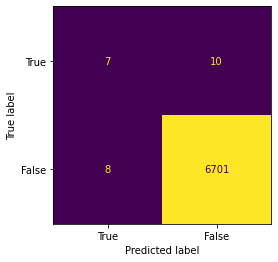

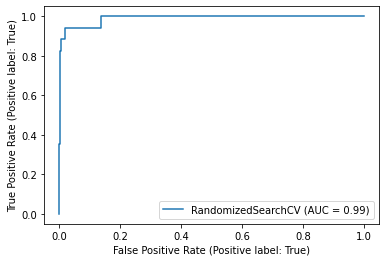

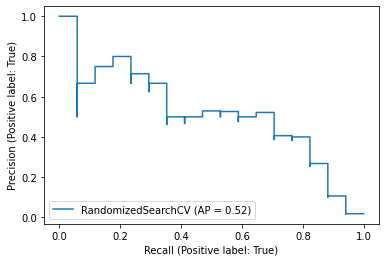

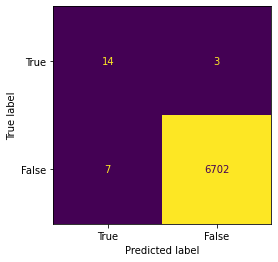

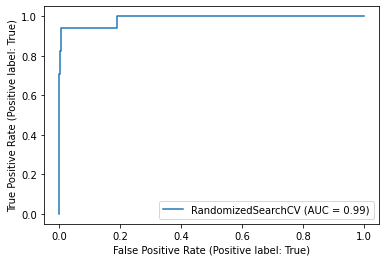

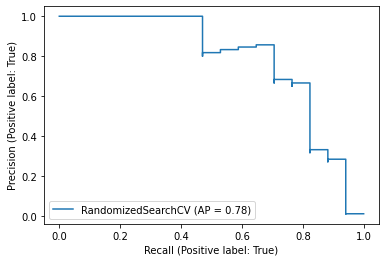

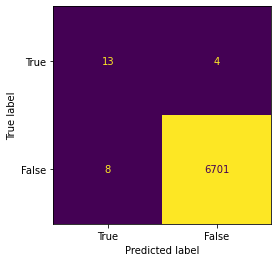

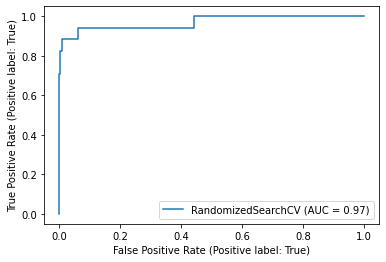

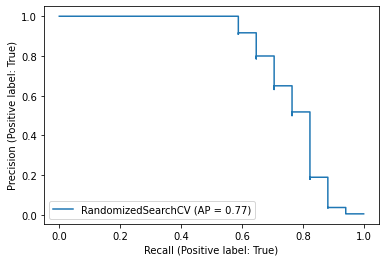

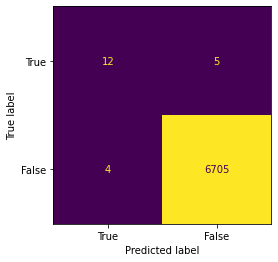

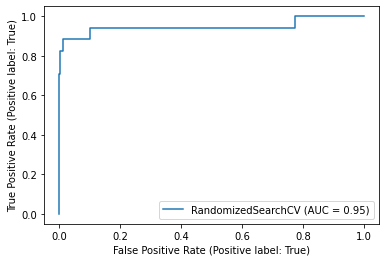

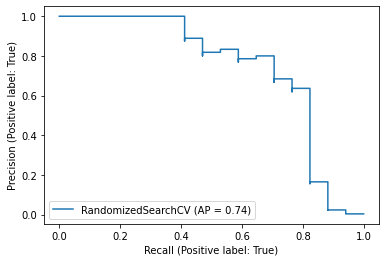

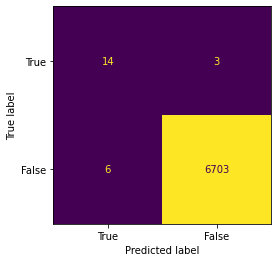

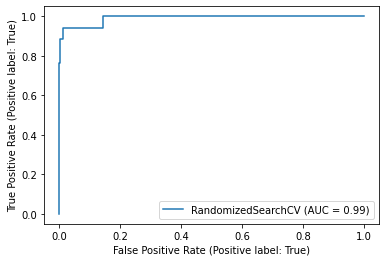

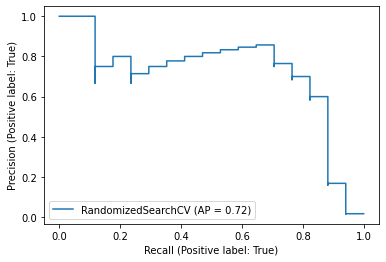

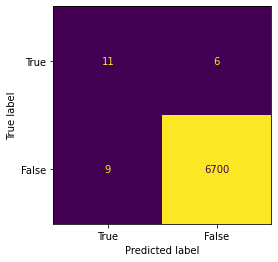

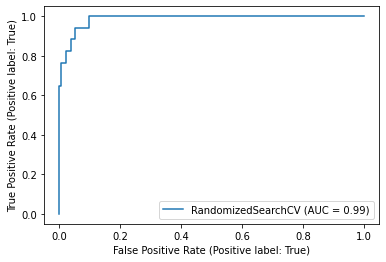

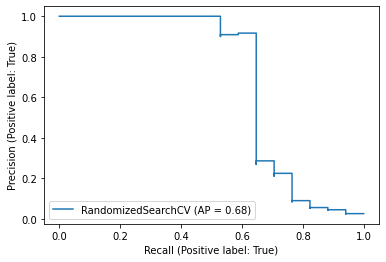

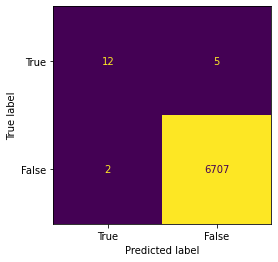

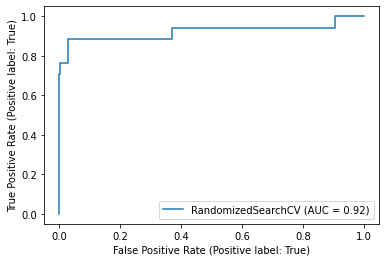

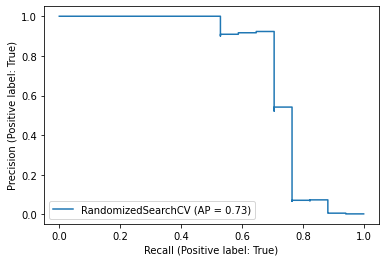

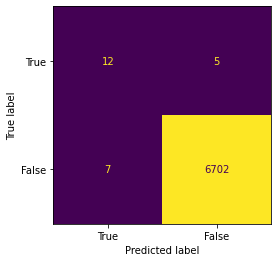

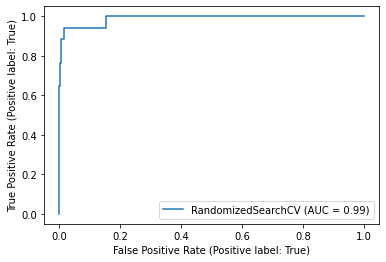

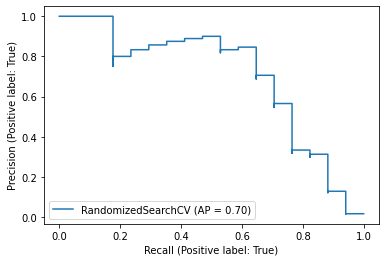

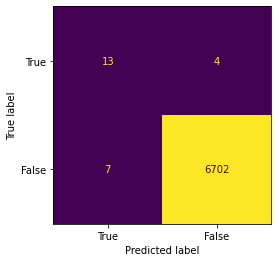

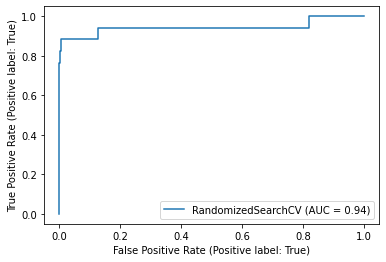

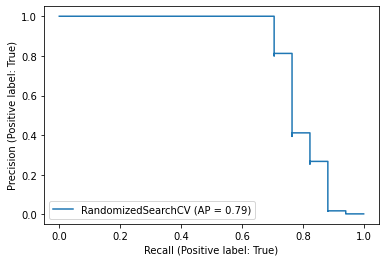

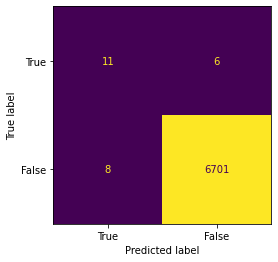

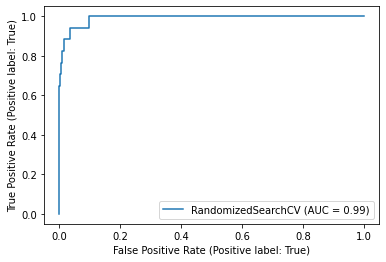

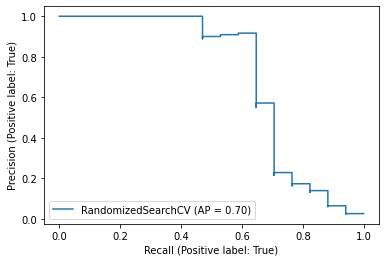

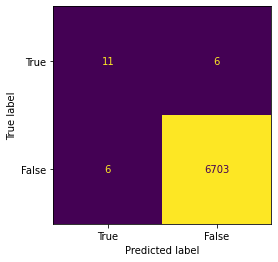

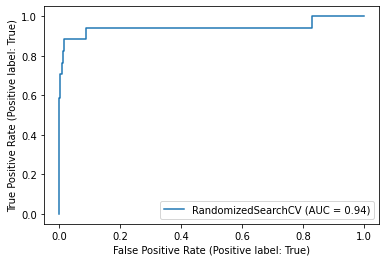

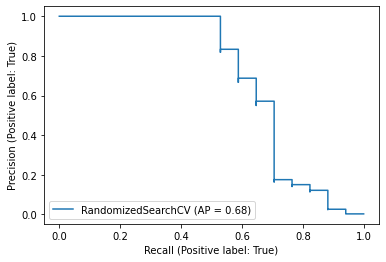

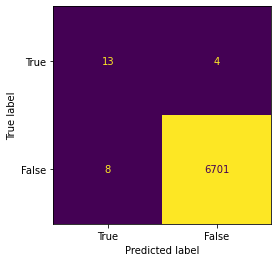

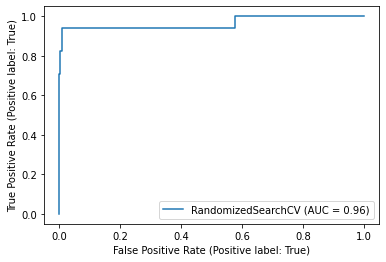

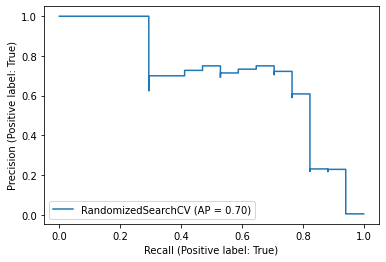

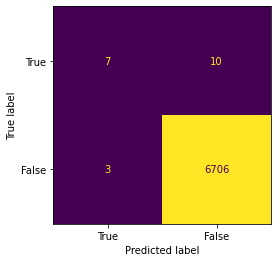

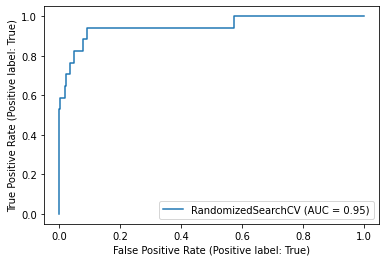

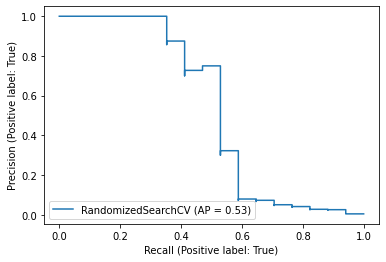

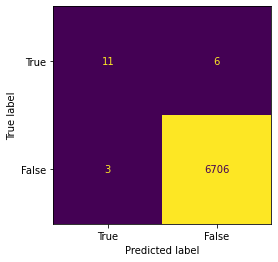

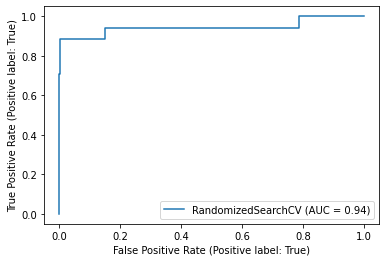

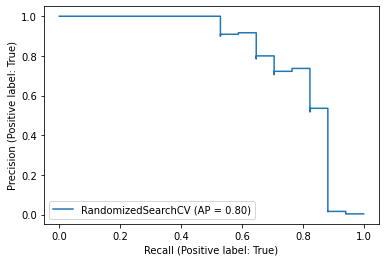

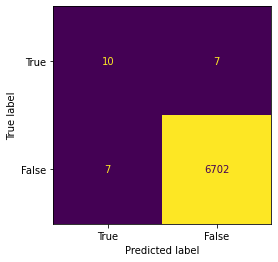

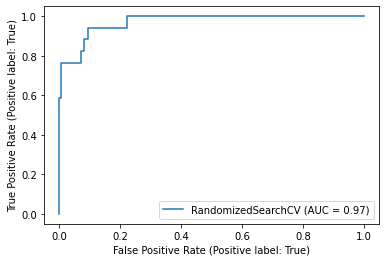

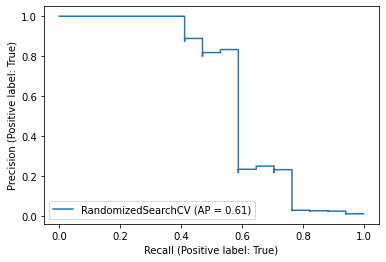

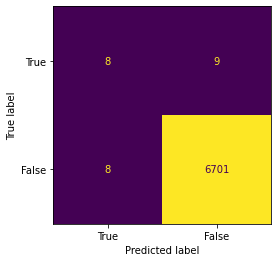

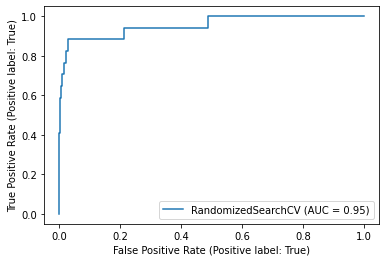

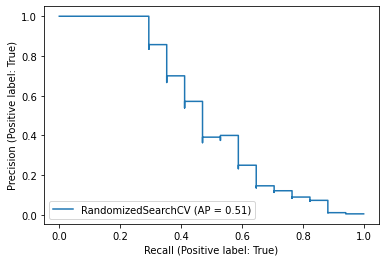

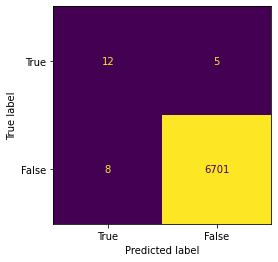

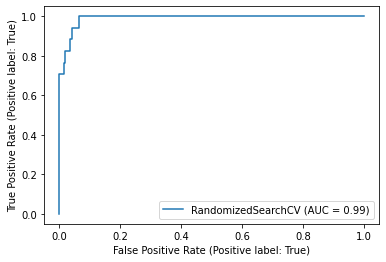

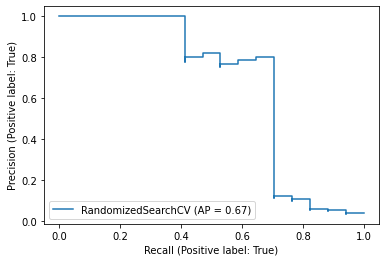

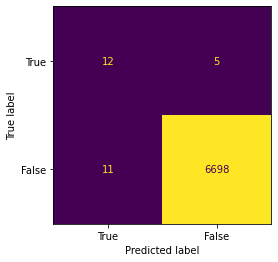

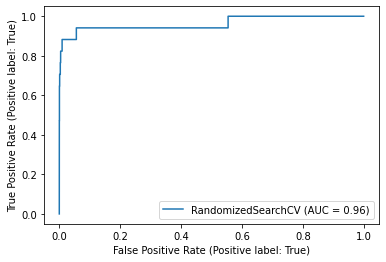

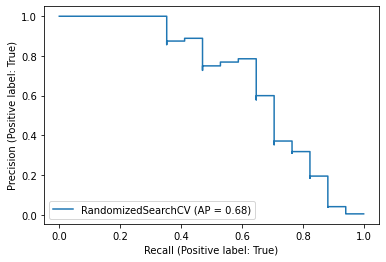

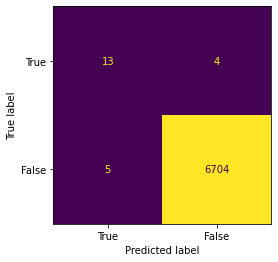

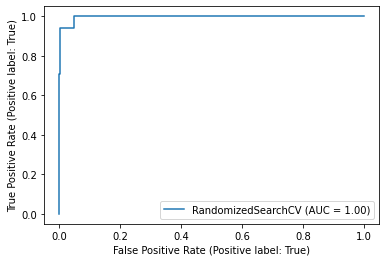

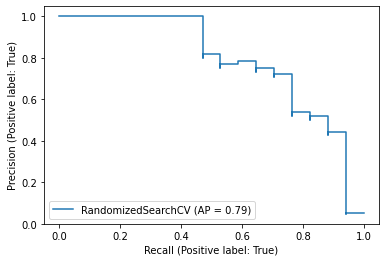

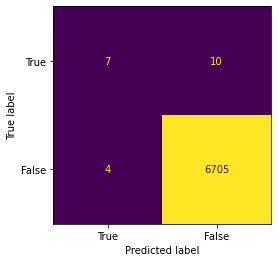

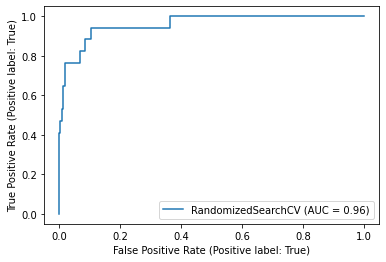

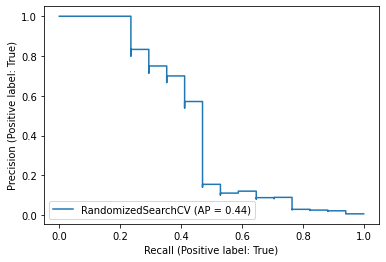

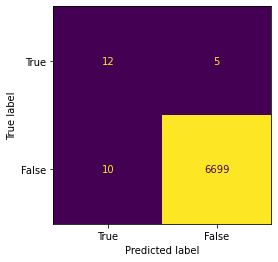

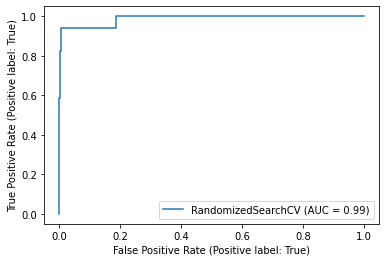

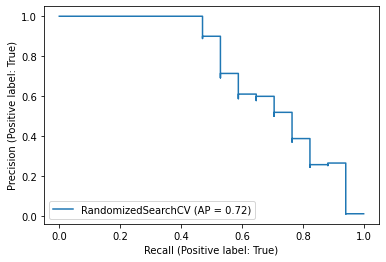

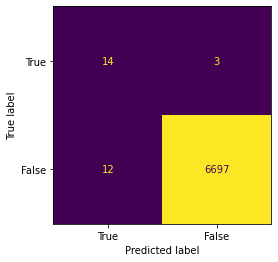

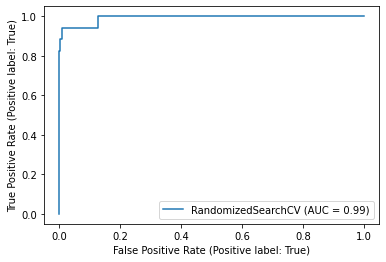

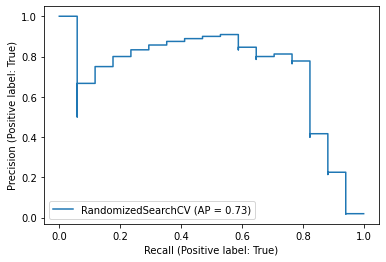

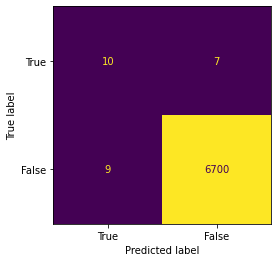

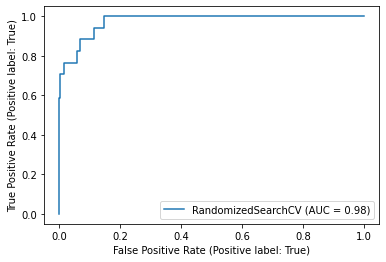

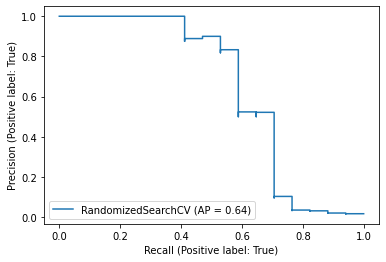

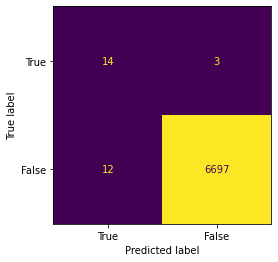

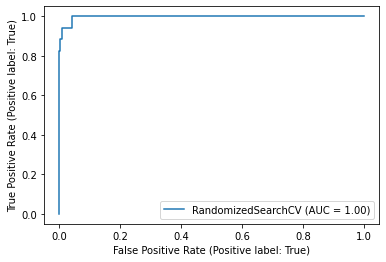

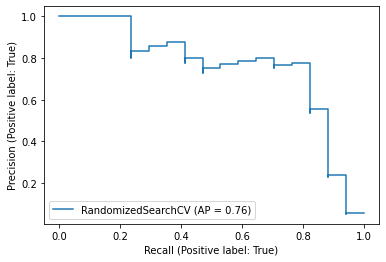

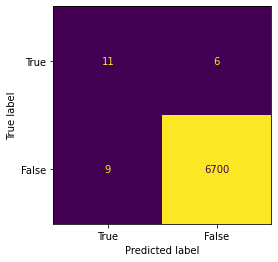

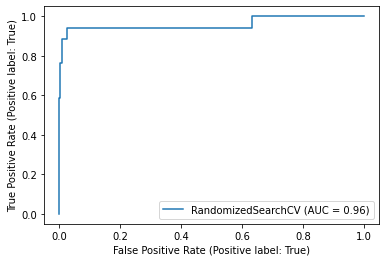

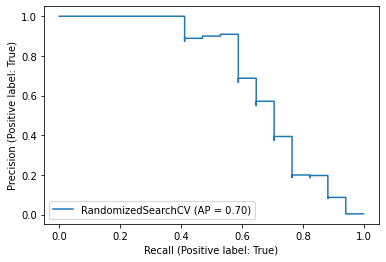

In [15]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb
ftwo_scorer = make_scorer(fbeta_score, beta=2)

for i in range(25):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2, importance_type='gain')]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__num_leaves'] = [11, 16, 21, 26, 31, 36, 41, 46, 51, 56]
    space['classifier__min_data_in_leaf'] =  [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__max_depth'] = [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
    space['classifier__max_bin'] = [50, 100, 150, 200, 255, 300, 350, 400, 450, 500]
    spaceEmpty = dict()


    LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedLightGBMModel.best_score_
    test_score = optimizedLightGBMModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)
    
    #feature importance
    importances = optimizedLightGBMModel.best_estimator_._final_estimator.booster_.feature_importance(importance_type='gain')
    for i,v in enumerate(importances):
        print(v)

    #Display the model performance    
    showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)